# Data Pre-Processing for Spotify Buddies

This notebook has most of the data preparation process for initiating our work on Spotify Buddies data. This is how the data would be originated in the business. This notebook also has steps for preparing the data for training, including splits between train, validation, and test data.

## Part 1: raw data and initial processing

In [ ]:
# ENTP Raw data converted to df
df = pl.read_parquet("/content/drive/MyDrive/datasets/entp_data/user_entp_df_raw")

# We get the song data for ENTP from the Million Song Playlist: http://millionsongdataset.com/
songs_df = pl.read_csv("/content/drive/MyDrive/datasets/entp_data/song_data.csv")

#We merge
merged_df = df.join(songs_df, left_on="songs_id", right_on="song_id", how="left")
merged_df.write_parquet("/content/drive/MyDrive/datasets/entp_data/merged_df")

merged_df = pl.read_parquet("/content/drive/MyDrive/datasets/entp_data/merged_df")

In [ ]:
# Group By
# User Id => Get the Songs List
users = merged_df['user_id'].unique()
# import time

In [ ]:
# Create Augmented Songs Id by concatenating title and artist name
merged_df = merged_df.with_columns(
    pl.concat_str(
        [
            pl.col("title"),
            pl.col("artist_name"),
        ],
        separator="",
    ).alias("aug_song_id"),
)

In [ ]:
curr_user = users[0]
tmp_df = merged_df.filter(pl.col("user_id") == curr_user)
# merged_df.head()
q = (
    tmp_df.lazy()
    .group_by("user_id")
    .agg(
        pl.col("aug_song_id"),
    )
)

test = q.collect()

### MPD Data:
For the MPD data, we just download the slices (there are about 100 slices), and we put them in a directory:

MPD_FOLDER = "/content/drive/My Drive/datasets/mpd_data"

#------------------------------------------------------------------------------------------------------------------------------

# Part 2) Processing MPD and ENTP separetely and create unique song_ids between the two datasets

In [ ]:
import json
from pathlib import Path

import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, issparse, vstack
import numpy as np

In [ ]:
MPD_FOLDER = "/content/drive/My Drive/datasets/mpd_data"

In [ ]:
# Replace with the actual path to your parquet file
parquet_path = '/content/drive/My Drive/datasets/entp_data/merged_df.parquet'
df = pl.read_parquet(parquet_path)

# Show first few rows
df.head()

shape: (5, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ user_id     ‚îÜ songs_id   ‚îÜ songs_coun ‚îÜ title      ‚îÜ release    ‚îÜ artist_nam ‚îÜ year ‚îÜ aug_song_i ‚îÇ
‚îÇ ---         ‚îÜ ---        ‚îÜ t          ‚îÜ ---        ‚îÜ ---        ‚îÜ e          ‚îÜ ---  ‚îÜ d          ‚îÇ
‚îÇ str         ‚îÜ str        ‚îÜ ---        ‚îÜ str        ‚îÜ str        ‚îÜ ---        ‚îÜ i64  ‚îÜ ---        ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ i64        ‚îÜ            ‚îÜ            ‚îÜ str        ‚îÜ      ‚îÜ str        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ b80344d063b ‚îÜ SOAKIMP12A ‚îÜ 1          ‚îÜ The Cove   ‚îÜ Thicker    ‚îÜ Jack       ‚îÜ 0    ‚îÜ The        ‚îÇ
‚îÇ 5ccb3212f76 ‚îÜ 8C130995   ‚îÜ            ‚îÜ            ‚îÜ Than Water ‚îÜ Johnson    ‚îÜ      ‚îÜ CoveJack   ‚îÇ
‚îÇ 538f3d9e‚Ä¶   ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ      ‚îÜ Johnson    ‚îÇ
‚îÇ b80344d063b ‚îÜ SOAPDEY12A ‚îÜ 1          ‚îÜ Nothing    ‚îÜ To Die For ‚îÜ Billy      ‚îÜ 1974 ‚îÜ Nothing    ‚îÇ
‚îÇ 5ccb3212f76 ‚îÜ 81C210A9   ‚îÜ            ‚îÜ from       ‚îÜ            ‚îÜ Preston    ‚îÜ      ‚îÜ from Nothi ‚îÇ
‚îÇ 538f3d9e‚Ä¶   ‚îÜ            ‚îÜ            ‚îÜ Nothing    ‚îÜ            ‚îÜ            ‚îÜ      ‚îÜ ngBilly    ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ      ‚îÜ Pres‚Ä¶      ‚îÇ
‚îÇ b80344d063b ‚îÜ SOBBMDR12A ‚îÜ 2          ‚îÜ Entre Dos  ‚îÜ Flamenco   ‚îÜ Paco De    ‚îÜ 1976 ‚îÜ Entre Dos  ‚îÇ
‚îÇ 5ccb3212f76 ‚îÜ 8C13253B   ‚îÜ            ‚îÜ Aguas      ‚îÜ Para Ni√±os ‚îÜ Lucia      ‚îÜ      ‚îÜ AguasPaco  ‚îÇ
‚îÇ 538f3d9e‚Ä¶   ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ      ‚îÜ De Lucia   ‚îÇ
‚îÇ b80344d063b ‚îÜ SOBFNSP12A ‚îÜ 1          ‚îÜ Under Cold ‚îÜ Under Cold ‚îÜ Josh Rouse ‚îÜ 2002 ‚îÜ Under Cold ‚îÇ
‚îÇ 5ccb3212f76 ‚îÜ F72A0E22   ‚îÜ            ‚îÜ Blue Stars ‚îÜ Blue Stars ‚îÜ            ‚îÜ      ‚îÜ Blue       ‚îÇ
‚îÇ 538f3d9e‚Ä¶   ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ      ‚îÜ StarsJosh  ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ      ‚îÜ Rous‚Ä¶      ‚îÇ
‚îÇ b80344d063b ‚îÜ SOBFOVM12A ‚îÜ 1          ‚îÜ Riot Radio ‚îÜ Nick &     ‚îÜ The Dead   ‚îÜ 0    ‚îÜ Riot Radio ‚îÇ
‚îÇ 5ccb3212f76 ‚îÜ 58A7D494   ‚îÜ            ‚îÜ (Soundtrac ‚îÜ Norah's    ‚îÜ 60s        ‚îÜ      ‚îÜ (Soundtrac ‚îÇ
‚îÇ 538f3d9e‚Ä¶   ‚îÜ            ‚îÜ            ‚îÜ k Version‚Ä¶ ‚îÜ Infinite   ‚îÜ            ‚îÜ      ‚îÜ k Version‚Ä¶ ‚îÇ
‚îÇ             ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ Playli‚Ä¶    ‚îÜ            ‚îÜ      ‚îÜ            ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
import os
import json
import pandas as pd
from tqdm import tqdm


# Load ENTP songs from merged_df
def extract_entp_songs(merged_df):
    entp_keys = set()
    for title, artist in zip(df['title'], df['artist_name']):
        if pd.notnull(title) and pd.notnull(artist):
            key = f"{title.strip().lower()}@@{artist.strip().lower()}"
            entp_keys.add(key)
    return entp_keys

In [ ]:
# Load MPD songs from JSON files


def extract_mpd_songs(mpd_folder):
    mpd_keys = set()
    files = [f for f in os.listdir(MPD_FOLDER) if f.endswith('.json')]

    for file in tqdm(files, desc="Processing MPD slices"):
        with open(os.path.join(MPD_FOLDER, file), 'r', encoding='utf-8') as f:
            try:
              data = json.load(f)
              for playlist in data['playlists']:
                  for track in playlist['tracks']:
                      title = track.get('track_name', '').strip().lower()
                      artist = track.get('artist_name', '').strip().lower()
                      if title and artist:
                          key = f"{title}@@{artist}"
                          mpd_keys.add(key)
            except:
              pass
    return mpd_keys

# Combine and assign unique song IDs
def build_song_id_mapping(merged_df, MPD_FOLDER):
    entp_keys = extract_entp_songs(merged_df)
    mpd_keys = extract_mpd_songs(MPD_FOLDER)
    all_song_keys = sorted(entp_keys | mpd_keys)

    song_to_id = {song: idx for idx, song in enumerate(all_song_keys)}
    return song_to_id

In [ ]:
# Generate song-to-ID mapping
song_to_id = build_song_id_mapping(df, "mpd_slices/")

print(f"Total unique songs: {len(song_to_id)}")

Processing MPD slices: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 947/947 [17:56<00:00,  1.14s/it]


Total unique songs: 2397197


In [ ]:
import pickle

# Save
with open("/content/drive/MyDrive/datasets/song_to_id.pkl", "wb") as f:
    pickle.dump(song_to_id, f)

# Load later
with open("/content/drive/MyDrive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)


In [ ]:
import pickle

# Load known song mappings
with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# Reload merged_df with song columns
merged_df = pd.read_parquet("/content/drive/My Drive/datasets/entp_data/merged_df.parquet", columns=["user_id", "title", "artist_name"])
merged_df.dropna(subset=["user_id", "title", "artist_name"], inplace=True)

# Create song keys
merged_df["title"] = merged_df["title"].str.strip().str.lower()
merged_df["artist_name"] = merged_df["artist_name"].str.strip().str.lower()
merged_df["song_key"] = merged_df["title"] + "@@" + merged_df["artist_name"]

# Filter to known songs
filtered_df = merged_df[merged_df["song_key"].isin(song_to_id)]
print(f"Users after filtering to known songs: {filtered_df['user_id'].nunique():,}")

‚úÖ Users after filtering to known songs: 1,019,318


### ---------------------------------------------------------------------------------------------
### DIVISION
### ---------------------------------------------------------------------------------------------

# Part 3) Users and playlists sparse matrices and dot product.

The goal of this part is to obtain the amount of matching songs between each user and each playlist. This is a 1M*1M grid, but each user and playlist have X and Y number of songs, so it's a very large operation. We use sparse matrices and slices to make it manageable and more efficient.

In [ ]:
# STEP 2: Build User Sparse Matrix

import pandas as pd
import pickle
import numpy as np
from scipy.sparse import csr_matrix

# === Load ENTP Parquet with only needed columns ===
merged_df = pd.read_parquet(
    "/content/drive/My Drive/datasets/entp_data/merged_df.parquet",
    columns=["user_id", "title", "artist_name"]
)

# === Load song_to_id mapping ===
with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# === Build user matrix function ===
def build_user_matrix(merged_df, song_to_id):
    print("Building user matrix...")

    user_ids = merged_df['user_id'].unique()
    user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
    n_users = len(user_to_idx)
    n_songs = len(song_to_id)

    print(f"Total users: {n_users}, Total songs: {n_songs}")

    data, row_indices, col_indices = [], [], []

    for row in merged_df.itertuples(index=False):
        if pd.notnull(row.title) and pd.notnull(row.artist_name):
            song_key = f"{row.title.strip().lower()}@@{row.artist_name.strip().lower()}"
            if song_key in song_to_id:
                user_idx = user_to_idx[row.user_id]
                song_idx = song_to_id[song_key]

                row_indices.append(user_idx)
                col_indices.append(song_idx)
                data.append(1)

    user_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(n_users, n_songs))

    return user_matrix, user_to_idx

In [ ]:
# Build user sparse matrix
user_matrix, user_to_idx = build_user_matrix(merged_df, song_to_id)

# Confirm shape
print("User matrix built:", user_matrix.shape)

# Save user_matrix
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "wb") as f:
    pickle.dump(user_matrix, f)

# Save user_to_idx
with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "wb") as f:
    pickle.dump(user_to_idx, f)

Building user matrix...
Total users: 1019318, Total songs: 2397197
User matrix built: (1019318, 2397197)


In [ ]:
# Load files (if needed)
# with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
#     user_matrix = pickle.load(f)

# with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "rb") as f:
#     user_to_idx = pickle.load(f)

In [ ]:
# Step 3: playlist sparse matrix builder function

import os
import json
import pickle
from tqdm import tqdm
from scipy.sparse import csr_matrix

def build_playlist_matrix(mpd_folder, song_to_id):
    print("Building playlist matrix...")

    data, row_indices, col_indices = [], [], []
    playlist_to_idx = {}
    playlist_counter = 0
    n_songs = len(song_to_id)

    json_files = [f for f in os.listdir(MPD_FOLDER) if f.endswith('.json')]

    for file in tqdm(json_files, desc="Processing MPD slices"):
      try:

        with open(os.path.join(mpd_folder, file), "r", encoding="utf-8") as f:
            slice_data = json.load(f)

            for playlist in slice_data["playlists"]:
                pid = playlist["pid"]
                playlist_to_idx[pid] = playlist_counter

                for track in playlist["tracks"]:
                    title = track.get("track_name", "").strip().lower()
                    artist = track.get("artist_name", "").strip().lower()
                    if title and artist:
                        key = f"{title}@@{artist}"
                        if key in song_to_id:
                            song_idx = song_to_id[key]

                            row_indices.append(playlist_counter)
                            col_indices.append(song_idx)
                            data.append(1)

                playlist_counter += 1

      except json.JSONDecodeError as e:
          print(f"Skipping file due to JSON error: {file} ‚Äî {e}")
          continue

    playlist_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(playlist_counter, n_songs))
    return playlist_matrix, playlist_to_idx



In [ ]:
# Step 3: generate the playlist sparse matrix

# Load song_to_id again (if not already in memory)
with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# Set path to your MPD slices
mpd_folder = "/content/drive/My Drive/datasets/mpd_data/"

# Build matrix
playlist_matrix, playlist_to_idx = build_playlist_matrix(mpd_folder, song_to_id)
print("Playlist matrix built:", playlist_matrix.shape)

# Save results
with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "wb") as f:
    pickle.dump(playlist_matrix, f)

with open("/content/drive/My Drive/datasets/playlist_to_idx.pkl", "wb") as f:
    pickle.dump(playlist_to_idx, f)

Building playlist matrix...


Processing MPD slices: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 947/947 [16:09<00:00,  1.02s/it]

Skipping file due to JSON error: mpd.slice.0-999.json ‚Äî Expecting ',' delimiter: line 21320 column 68 (char 1048597)


Playlist matrix built: (946000, 2397197)


In [ ]:
#Step 3: load files (if required)
# # Load files
# merged_df = pd.read_parquet(
#     "/content/drive/My Drive/datasets/entp_data/merged_df.parquet",
#     columns=["user_id", "title", "artist_name"]
# )
# with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
#     song_to_id = pickle.load(f)

# # Build matrix
# user_matrix, user_to_idx = build_user_matrix(merged_df, song_to_id)
# print("User matrix built:", user_matrix.shape)

In [ ]:
import os
import pickle
import re
from pathlib import Path
from scipy.sparse import load_npz, csr_matrix
from tqdm import tqdm

# === Path to overlap_batches
batch_dir = Path("/content/drive/My Drive/datasets/overlap_batches")
pkl_files = sorted(batch_dir.glob("overlap_*.pkl"))

print(f"Found {len(pkl_files)} overlap batch files.\n")

# === Analyze contents of each
for file_path in tqdm(pkl_files[:10], desc=" Inspecting first 10 batches"):
    start = int(re.search(r"overlap_(\d+)_\d+\.pkl", file_path.name).group(1))

    with open(file_path, "rb") as f:
        sparse_matrix = pickle.load(f)

    coo = sparse_matrix.tocoo()
    nnz = coo.nnz
    unique_users = len(set(coo.row))
    unique_playlists = len(set(coo.col))

    print(f"\n {file_path.name}")
    print(f"- Shape         : {sparse_matrix.shape}")
    print(f"- Nonzeros      : {nnz}")
    print(f"- Unique users  : {unique_users} (min={coo.row.min()}, max={coo.row.max()})")
    print(f"- Unique plists : {unique_playlists} (min={coo.col.min()}, max={coo.col.max()})")
    print(f"- Values range  : min={coo.data.min()}, max={coo.data.max()}")

    # Check if row indices go from 0 to N-1 (batch local) or are already global
    if coo.row.max() >= sparse_matrix.shape[0]:
        print("Warning")
    elif coo.row.max() < 10000:
        print("Row indices look batch-local (expected).")


In [ ]:
# Step 4: compute matches between both matrics (user and playlists)

# === Load matrices ===
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
    user_matrix = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "rb") as f:
    playlist_matrix = pickle.load(f)


# === Multiply to get user‚Äìplaylist overlaps ===
print("Computing overlap matrix...")
playlist_matrix_T = playlist_matrix.transpose().tocsr()
overlap_matrix = user_matrix.dot(playlist_matrix_T)  # shape: (n_users, n_playlists)

print("Done! Overlap matrix shape:", overlap_matrix.shape)


with open("/content/drive/My Drive/datasets/overlap_matrix.pkl", "wb") as f:
    pickle.dump(overlap_matrix, f)

KeyboardInterrupt: 

In [ ]:
# Step 4: compute matches between both matrics (user and playlists) with batched multiplication


# === Load matrices ===
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
    user_matrix = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "rb") as f:
    playlist_matrix = pickle.load(f)

playlist_matrix_T = playlist_matrix.transpose().tocsr()

# === Set batch parameters ===
batch_size = 10000
n_users = user_matrix.shape[0]

print("Starting streaming batched dot product...")

for start in range(0, n_users, batch_size):
    end = min(start + batch_size, n_users)
    batch = user_matrix[start:end]

    print(f"Processing users {start} to {end}...")

    batch_overlap = batch.dot(playlist_matrix_T)

    batch_file = f"/content/drive/My Drive/datasets/overlap_batches/overlap_{start}_{end}.pkl"
    with open(batch_file, "wb") as f:
        pickle.dump(batch_overlap, f)

print("‚úÖ All batches saved to disk.")

KeyboardInterrupt: 

In [ ]:
import os
import pickle
from scipy.sparse import csr_matrix

# === Load matrices ===
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
    user_matrix = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "rb") as f:
    playlist_matrix = pickle.load(f)

playlist_matrix_T = playlist_matrix.transpose().tocsr()

# === Set batch parameters ===
batch_size = 10000
n_users = user_matrix.shape[0]

output_dir = "/content/drive/My Drive/datasets/overlap_batches"
os.makedirs(output_dir, exist_ok=True)

print("Starting streaming batched dot product...")

for start in range(0, n_users, batch_size):
    end = min(start + batch_size, n_users)
    batch_file = os.path.join(output_dir, f"overlap_{start}_{end}.pkl")

    if os.path.exists(batch_file):
        print(f"‚úÖ overlap_{start}_{end} already computed. Skipping...")
        continue

    print(f"Processing users {start} to {end}...")

    batch = user_matrix[start:end]
    batch_overlap = batch.dot(playlist_matrix_T)

    with open(batch_file, "wb") as f:
        pickle.dump(batch_overlap, f)

print("All missing batches processed and saved.")

Starting streaming batched dot product...
‚úÖ overlap_0_10000 already computed. Skipping...
‚úÖ overlap_10000_20000 already computed. Skipping...
‚úÖ overlap_20000_30000 already computed. Skipping...
‚úÖ overlap_30000_40000 already computed. Skipping...
‚úÖ overlap_40000_50000 already computed. Skipping...
‚úÖ overlap_50000_60000 already computed. Skipping...
‚úÖ overlap_60000_70000 already computed. Skipping...
‚úÖ overlap_70000_80000 already computed. Skipping...
‚úÖ overlap_80000_90000 already computed. Skipping...
‚úÖ overlap_90000_100000 already computed. Skipping...
‚úÖ overlap_100000_110000 already computed. Skipping...
‚úÖ overlap_110000_120000 already computed. Skipping...
‚úÖ overlap_120000_130000 already computed. Skipping...
‚úÖ overlap_130000_140000 already computed. Skipping...
‚úÖ overlap_140000_150000 already computed. Skipping...
‚úÖ overlap_150000_160000 already computed. Skipping...
‚úÖ overlap_160000_170000 already computed. Skipping...
‚úÖ overlap_170000_180000 alr

We fix some errors with the batches:

In [ ]:
import os
import re
import gc
import pickle
import polars as pl
from tqdm import tqdm
from pathlib import Path
from scipy.sparse import coo_matrix

# === Paths ===
batch_dir = Path("/content/drive/MyDrive/datasets/overlap_batches")
output_dir = Path("/content/drive/MyDrive/datasets/overlap_processed_fixed")
output_dir.mkdir(parents=True, exist_ok=True)

# === Gather batch files sorted by starting user index ===
pkl_files = sorted(
    batch_dir.glob("overlap_*.pkl"),
    key=lambda f: int(re.search(r"overlap_(\d+)_\d+\.pkl", f.name).group(1))
)

# === Process each file ===
for file_path in tqdm(pkl_files, desc="Regenerating overlap_processed"):
    match = re.search(r"overlap_(\d+)_(\d+)\.pkl", file_path.name)
    if not match:
        print(f"Skipping malformed filename: {file_path.name}")
        continue

    start_idx = int(match.group(1))

    with open(file_path, "rb") as f:
        sparse_matrix = pickle.load(f)

    coo: coo_matrix = sparse_matrix.tocoo()
    del sparse_matrix
    gc.collect()

    # Shift user indices globally
    df = pl.DataFrame({
        "user_id": coo.row + start_idx,
        "playlist_id": coo.col,
        "song_count": coo.data
    })
    del coo
    gc.collect()

    # Save as Parquet
    output_file = output_dir / f"{file_path.stem}.parquet"
    df.write_parquet(output_file, compression="snappy")
    del df
    gc.collect()

    print(f"‚úÖ Saved {output_file.name}")

print(f"\n All slices regenerated and saved to {output_dir}")


üöß Regenerating overlap_processed:   1%|          | 1/102 [01:03<1:46:03, 63.01s/it]

‚úÖ Saved overlap_0_10000.parquet


üöß Regenerating overlap_processed:   2%|‚ñè         | 2/102 [02:27<2:05:35, 75.35s/it]

‚úÖ Saved overlap_10000_20000.parquet


üöß Regenerating overlap_processed:   3%|‚ñé         | 3/102 [03:38<2:01:22, 73.56s/it]

‚úÖ Saved overlap_20000_30000.parquet


üöß Regenerating overlap_processed:   4%|‚ñç         | 4/102 [04:45<1:55:59, 71.02s/it]

‚úÖ Saved overlap_30000_40000.parquet


üöß Regenerating overlap_processed:   5%|‚ñç         | 5/102 [05:44<1:47:35, 66.55s/it]

‚úÖ Saved overlap_40000_50000.parquet


üöß Regenerating overlap_processed:   6%|‚ñå         | 6/102 [06:41<1:41:12, 63.26s/it]

‚úÖ Saved overlap_50000_60000.parquet


üöß Regenerating overlap_processed:   7%|‚ñã         | 7/102 [07:40<1:37:56, 61.86s/it]

‚úÖ Saved overlap_60000_70000.parquet


üöß Regenerating overlap_processed:   8%|‚ñä         | 8/102 [08:36<1:34:25, 60.27s/it]

‚úÖ Saved overlap_70000_80000.parquet


üöß Regenerating overlap_processed:   9%|‚ñâ         | 9/102 [09:35<1:32:39, 59.78s/it]

‚úÖ Saved overlap_80000_90000.parquet


üöß Regenerating overlap_processed:  10%|‚ñâ         | 10/102 [10:35<1:31:51, 59.91s/it]

‚úÖ Saved overlap_90000_100000.parquet


üöß Regenerating overlap_processed:  11%|‚ñà         | 11/102 [11:55<1:39:53, 65.86s/it]

‚úÖ Saved overlap_100000_110000.parquet


üöß Regenerating overlap_processed:  12%|‚ñà‚ñè        | 12/102 [13:08<1:42:03, 68.04s/it]

‚úÖ Saved overlap_110000_120000.parquet


üöß Regenerating overlap_processed:  13%|‚ñà‚ñé        | 13/102 [14:18<1:42:09, 68.87s/it]

‚úÖ Saved overlap_120000_130000.parquet


üöß Regenerating overlap_processed:  14%|‚ñà‚ñé        | 14/102 [15:36<1:44:46, 71.43s/it]

‚úÖ Saved overlap_130000_140000.parquet


üöß Regenerating overlap_processed:  15%|‚ñà‚ñç        | 15/102 [16:47<1:43:35, 71.45s/it]

‚úÖ Saved overlap_140000_150000.parquet


üöß Regenerating overlap_processed:  16%|‚ñà‚ñå        | 16/102 [18:00<1:42:44, 71.68s/it]

‚úÖ Saved overlap_150000_160000.parquet


üöß Regenerating overlap_processed:  17%|‚ñà‚ñã        | 17/102 [19:08<1:40:16, 70.79s/it]

‚úÖ Saved overlap_160000_170000.parquet


üöß Regenerating overlap_processed:  18%|‚ñà‚ñä        | 18/102 [20:17<1:38:05, 70.06s/it]

‚úÖ Saved overlap_170000_180000.parquet


üöß Regenerating overlap_processed:  19%|‚ñà‚ñä        | 19/102 [21:28<1:37:38, 70.59s/it]

‚úÖ Saved overlap_180000_190000.parquet


üöß Regenerating overlap_processed:  20%|‚ñà‚ñâ        | 20/102 [22:52<1:41:53, 74.55s/it]

‚úÖ Saved overlap_190000_200000.parquet


üöß Regenerating overlap_processed:  21%|‚ñà‚ñà        | 21/102 [24:01<1:38:29, 72.96s/it]

‚úÖ Saved overlap_200000_210000.parquet


üöß Regenerating overlap_processed:  22%|‚ñà‚ñà‚ñè       | 22/102 [25:15<1:37:30, 73.13s/it]

‚úÖ Saved overlap_210000_220000.parquet


üöß Regenerating overlap_processed:  23%|‚ñà‚ñà‚ñé       | 23/102 [26:27<1:35:41, 72.68s/it]

‚úÖ Saved overlap_220000_230000.parquet


üöß Regenerating overlap_processed:  24%|‚ñà‚ñà‚ñé       | 24/102 [27:37<1:33:42, 72.09s/it]

‚úÖ Saved overlap_230000_240000.parquet


üöß Regenerating overlap_processed:  25%|‚ñà‚ñà‚ñç       | 25/102 [28:46<1:31:15, 71.11s/it]

‚úÖ Saved overlap_240000_250000.parquet


üöß Regenerating overlap_processed:  25%|‚ñà‚ñà‚ñå       | 26/102 [29:53<1:28:33, 69.92s/it]

‚úÖ Saved overlap_250000_260000.parquet


üöß Regenerating overlap_processed:  26%|‚ñà‚ñà‚ñã       | 27/102 [30:59<1:25:56, 68.76s/it]

‚úÖ Saved overlap_260000_270000.parquet


üöß Regenerating overlap_processed:  27%|‚ñà‚ñà‚ñã       | 28/102 [32:11<1:25:56, 69.68s/it]

‚úÖ Saved overlap_270000_280000.parquet


üöß Regenerating overlap_processed:  28%|‚ñà‚ñà‚ñä       | 29/102 [33:40<1:31:53, 75.52s/it]

‚úÖ Saved overlap_280000_290000.parquet


üöß Regenerating overlap_processed:  29%|‚ñà‚ñà‚ñâ       | 30/102 [34:49<1:28:18, 73.59s/it]

‚úÖ Saved overlap_290000_300000.parquet


üöß Regenerating overlap_processed:  30%|‚ñà‚ñà‚ñà       | 31/102 [36:00<1:25:51, 72.56s/it]

‚úÖ Saved overlap_300000_310000.parquet


üöß Regenerating overlap_processed:  31%|‚ñà‚ñà‚ñà‚ñè      | 32/102 [37:05<1:22:12, 70.46s/it]

‚úÖ Saved overlap_310000_320000.parquet


üöß Regenerating overlap_processed:  32%|‚ñà‚ñà‚ñà‚ñè      | 33/102 [38:13<1:20:14, 69.77s/it]

‚úÖ Saved overlap_320000_330000.parquet


üöß Regenerating overlap_processed:  33%|‚ñà‚ñà‚ñà‚ñé      | 34/102 [39:27<1:20:29, 71.03s/it]

‚úÖ Saved overlap_330000_340000.parquet


üöß Regenerating overlap_processed:  34%|‚ñà‚ñà‚ñà‚ñç      | 35/102 [40:25<1:14:58, 67.14s/it]

‚úÖ Saved overlap_340000_350000.parquet


üöß Regenerating overlap_processed:  35%|‚ñà‚ñà‚ñà‚ñå      | 36/102 [41:24<1:10:57, 64.50s/it]

‚úÖ Saved overlap_350000_360000.parquet


üöß Regenerating overlap_processed:  36%|‚ñà‚ñà‚ñà‚ñã      | 37/102 [42:26<1:09:12, 63.88s/it]

‚úÖ Saved overlap_360000_370000.parquet


üöß Regenerating overlap_processed:  37%|‚ñà‚ñà‚ñà‚ñã      | 38/102 [43:40<1:11:26, 66.98s/it]

‚úÖ Saved overlap_370000_380000.parquet


üöß Regenerating overlap_processed:  38%|‚ñà‚ñà‚ñà‚ñä      | 39/102 [44:53<1:11:58, 68.55s/it]

‚úÖ Saved overlap_380000_390000.parquet


üöß Regenerating overlap_processed:  39%|‚ñà‚ñà‚ñà‚ñâ      | 40/102 [45:51<1:07:39, 65.48s/it]

‚úÖ Saved overlap_390000_400000.parquet


üöß Regenerating overlap_processed:  40%|‚ñà‚ñà‚ñà‚ñà      | 41/102 [46:44<1:02:47, 61.76s/it]

‚úÖ Saved overlap_400000_410000.parquet


üöß Regenerating overlap_processed:  41%|‚ñà‚ñà‚ñà‚ñà      | 42/102 [47:45<1:01:42, 61.70s/it]

‚úÖ Saved overlap_410000_420000.parquet


üöß Regenerating overlap_processed:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 43/102 [48:42<59:04, 60.07s/it]  

‚úÖ Saved overlap_420000_430000.parquet


üöß Regenerating overlap_processed:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 44/102 [49:34<55:54, 57.83s/it]

‚úÖ Saved overlap_430000_440000.parquet


üöß Regenerating overlap_processed:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 45/102 [50:33<55:07, 58.03s/it]

‚úÖ Saved overlap_440000_450000.parquet


üöß Regenerating overlap_processed:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 46/102 [51:29<53:39, 57.49s/it]

‚úÖ Saved overlap_450000_460000.parquet


üöß Regenerating overlap_processed:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 47/102 [52:31<53:47, 58.68s/it]

‚úÖ Saved overlap_460000_470000.parquet


üöß Regenerating overlap_processed:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 48/102 [53:28<52:34, 58.42s/it]

‚úÖ Saved overlap_470000_480000.parquet


üöß Regenerating overlap_processed:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 49/102 [54:46<56:35, 64.06s/it]

‚úÖ Saved overlap_480000_490000.parquet


üöß Regenerating overlap_processed:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 50/102 [55:46<54:37, 63.02s/it]

‚úÖ Saved overlap_490000_500000.parquet


üöß Regenerating overlap_processed:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 51/102 [56:50<53:40, 63.14s/it]

‚úÖ Saved overlap_500000_510000.parquet


üöß Regenerating overlap_processed:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 52/102 [57:50<52:02, 62.45s/it]

‚úÖ Saved overlap_510000_520000.parquet


üöß Regenerating overlap_processed:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 53/102 [58:51<50:27, 61.80s/it]

‚úÖ Saved overlap_520000_530000.parquet


üöß Regenerating overlap_processed:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 54/102 [59:49<48:38, 60.81s/it]

‚úÖ Saved overlap_530000_540000.parquet


üöß Regenerating overlap_processed:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 55/102 [1:01:10<52:16, 66.73s/it]

‚úÖ Saved overlap_540000_550000.parquet


üöß Regenerating overlap_processed:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 56/102 [1:02:18<51:24, 67.06s/it]

‚úÖ Saved overlap_550000_560000.parquet


üöß Regenerating overlap_processed:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 57/102 [1:03:19<48:56, 65.25s/it]

‚úÖ Saved overlap_560000_570000.parquet


üöß Regenerating overlap_processed:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 58/102 [1:04:16<46:02, 62.80s/it]

‚úÖ Saved overlap_570000_580000.parquet


üöß Regenerating overlap_processed:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 59/102 [1:05:47<51:12, 71.45s/it]

‚úÖ Saved overlap_580000_590000.parquet


üöß Regenerating overlap_processed:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 60/102 [1:06:47<47:36, 68.01s/it]

‚úÖ Saved overlap_590000_600000.parquet


üöß Regenerating overlap_processed:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 61/102 [1:07:54<46:11, 67.59s/it]

‚úÖ Saved overlap_600000_610000.parquet


üöß Regenerating overlap_processed:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 62/102 [1:08:56<43:55, 65.88s/it]

‚úÖ Saved overlap_610000_620000.parquet


üöß Regenerating overlap_processed:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 63/102 [1:09:54<41:18, 63.56s/it]

‚úÖ Saved overlap_620000_630000.parquet


üöß Regenerating overlap_processed:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 64/102 [1:10:55<39:44, 62.74s/it]

‚úÖ Saved overlap_630000_640000.parquet


üöß Regenerating overlap_processed:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 65/102 [1:11:54<38:04, 61.73s/it]

‚úÖ Saved overlap_640000_650000.parquet


üöß Regenerating overlap_processed:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 66/102 [1:12:55<36:56, 61.58s/it]

‚úÖ Saved overlap_650000_660000.parquet


üöß Regenerating overlap_processed:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 67/102 [1:13:56<35:48, 61.38s/it]

‚úÖ Saved overlap_660000_670000.parquet


üöß Regenerating overlap_processed:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 68/102 [1:14:57<34:37, 61.09s/it]

‚úÖ Saved overlap_670000_680000.parquet


üöß Regenerating overlap_processed:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 69/102 [1:16:18<36:56, 67.18s/it]

‚úÖ Saved overlap_680000_690000.parquet


üöß Regenerating overlap_processed:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 70/102 [1:17:18<34:36, 64.89s/it]

‚úÖ Saved overlap_690000_700000.parquet


üöß Regenerating overlap_processed:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 71/102 [1:18:19<33:01, 63.92s/it]

‚úÖ Saved overlap_700000_710000.parquet


üöß Regenerating overlap_processed:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 72/102 [1:19:35<33:41, 67.40s/it]

‚úÖ Saved overlap_710000_720000.parquet


üöß Regenerating overlap_processed:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 73/102 [1:20:38<31:58, 66.15s/it]

‚úÖ Saved overlap_720000_730000.parquet


üöß Regenerating overlap_processed:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 74/102 [1:21:42<30:36, 65.59s/it]

‚úÖ Saved overlap_730000_740000.parquet


üöß Regenerating overlap_processed:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 75/102 [1:22:45<29:09, 64.79s/it]

‚úÖ Saved overlap_740000_750000.parquet


üöß Regenerating overlap_processed:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 76/102 [1:23:50<28:06, 64.86s/it]

‚úÖ Saved overlap_750000_760000.parquet


üöß Regenerating overlap_processed:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 77/102 [1:24:53<26:45, 64.22s/it]

‚úÖ Saved overlap_760000_770000.parquet


üöß Regenerating overlap_processed:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 78/102 [1:25:49<24:42, 61.77s/it]

‚úÖ Saved overlap_770000_780000.parquet


üöß Regenerating overlap_processed:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 79/102 [1:27:09<25:43, 67.11s/it]

‚úÖ Saved overlap_780000_790000.parquet


üöß Regenerating overlap_processed:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 80/102 [1:28:09<23:53, 65.17s/it]

‚úÖ Saved overlap_790000_800000.parquet


üöß Regenerating overlap_processed:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 81/102 [1:29:14<22:47, 65.12s/it]

‚úÖ Saved overlap_800000_810000.parquet


üöß Regenerating overlap_processed:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 82/102 [1:30:18<21:36, 64.80s/it]

‚úÖ Saved overlap_810000_820000.parquet


üöß Regenerating overlap_processed:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 83/102 [1:31:22<20:22, 64.36s/it]

‚úÖ Saved overlap_820000_830000.parquet


üöß Regenerating overlap_processed:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 84/102 [1:32:24<19:06, 63.69s/it]

‚úÖ Saved overlap_830000_840000.parquet


üöß Regenerating overlap_processed:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 85/102 [1:33:29<18:11, 64.21s/it]

‚úÖ Saved overlap_840000_850000.parquet


üöß Regenerating overlap_processed:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 86/102 [1:34:33<17:04, 64.05s/it]

‚úÖ Saved overlap_850000_860000.parquet


üöß Regenerating overlap_processed:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 87/102 [1:35:34<15:48, 63.23s/it]

‚úÖ Saved overlap_860000_870000.parquet


üöß Regenerating overlap_processed:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 88/102 [1:36:26<13:55, 59.71s/it]

‚úÖ Saved overlap_870000_880000.parquet


üöß Regenerating overlap_processed:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 89/102 [1:37:36<13:37, 62.92s/it]

‚úÖ Saved overlap_880000_890000.parquet


üöß Regenerating overlap_processed:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 90/102 [1:38:34<12:17, 61.44s/it]

‚úÖ Saved overlap_890000_900000.parquet


üöß Regenerating overlap_processed:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 91/102 [1:39:24<10:38, 58.03s/it]

‚úÖ Saved overlap_900000_910000.parquet


üöß Regenerating overlap_processed:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 92/102 [1:40:17<09:23, 56.40s/it]

‚úÖ Saved overlap_910000_920000.parquet


üöß Regenerating overlap_processed:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 93/102 [1:41:08<08:12, 54.71s/it]

‚úÖ Saved overlap_920000_930000.parquet


üöß Regenerating overlap_processed:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 94/102 [1:42:00<07:11, 53.98s/it]

‚úÖ Saved overlap_930000_940000.parquet


üöß Regenerating overlap_processed:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 95/102 [1:42:50<06:10, 52.91s/it]

‚úÖ Saved overlap_940000_950000.parquet


üöß Regenerating overlap_processed:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 96/102 [1:43:42<05:15, 52.60s/it]

‚úÖ Saved overlap_950000_960000.parquet


üöß Regenerating overlap_processed:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 97/102 [1:44:37<04:26, 53.22s/it]

‚úÖ Saved overlap_960000_970000.parquet


üöß Regenerating overlap_processed:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 98/102 [1:45:27<03:29, 52.29s/it]

‚úÖ Saved overlap_970000_980000.parquet


üöß Regenerating overlap_processed:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 99/102 [1:46:19<02:36, 52.18s/it]

‚úÖ Saved overlap_980000_990000.parquet


üöß Regenerating overlap_processed:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 100/102 [1:47:09<01:43, 51.60s/it]

‚úÖ Saved overlap_990000_1000000.parquet


üöß Regenerating overlap_processed:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 101/102 [1:48:20<00:57, 57.42s/it]

‚úÖ Saved overlap_1000000_1010000.parquet


üöß Regenerating overlap_processed: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [1:49:32<00:00, 64.44s/it]

‚úÖ Saved overlap_1010000_1019318.parquet

 All slices regenerated and saved to /content/drive/MyDrive/datasets/overlap_processed_fixed


### Make sure we can map these positional id's to the real id's if we need to: Creating a mapping from idx used in sparse matrices to real IDs both for users (ENTP) and playlists (MPD

In [ ]:
import pickle
import pandas as pd

# === Load mappings from pickle ===
with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "rb") as f:
    user_to_idx = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_to_idx.pkl", "rb") as f:
    playlist_to_idx = pickle.load(f)

print("‚úÖ Loaded user_to_idx:", len(user_to_idx))
print("‚úÖ Loaded playlist_to_idx:", len(playlist_to_idx))

# === Invert mappings ===
idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_playlist = {v: k for k, v in playlist_to_idx.items()}

print("‚úÖ Inverted mappings created.")

# === Convert to DataFrames and save as Parquet ===
user_df = pd.DataFrame(list(idx_to_user.items()), columns=["user_idx", "user_id"])
playlist_df = pd.DataFrame(list(idx_to_playlist.items()), columns=["playlist_idx", "playlist_id"])

user_df.to_parquet("/content/drive/My Drive/datasets/idx_to_user.parquet", index=False)
playlist_df.to_parquet("/content/drive/My Drive/datasets/idx_to_playlist.parquet", index=False)

print("üíæ Saved to:")
print("- /content/drive/My Drive/datasets/idx_to_user.parquet")
print("- /content/drive/My Drive/datasets/idx_to_playlist.parquet")

‚úÖ Loaded user_to_idx: 1019318
‚úÖ Loaded playlist_to_idx: 946000
‚úÖ Inverted mappings created.
üíæ Saved to:
- /content/drive/My Drive/datasets/idx_to_user.parquet
- /content/drive/My Drive/datasets/idx_to_playlist.parquet


In [ ]:
#Checking that everything went well. And it did :)
print("First 5 entries in user_to_idx mapping:")
for i, (user_id, idx) in enumerate(user_to_idx.items()):
    print(f"{i+1}. user_id: {user_id} ‚Üí index: {idx}")
    if i == 4:
        break
print(len(user_to_idx))

üîç First 5 entries in user_to_idx mapping:
1. user_id: b80344d063b5ccb3212f76538f3d9e43d87dca9e ‚Üí index: 0
2. user_id: 85c1f87fea955d09b4bec2e36aee110927aedf9a ‚Üí index: 1
3. user_id: bd4c6e843f00bd476847fb75c47b4fb430a06856 ‚Üí index: 2
4. user_id: 8937134734f869debcab8f23d77465b4caaa85df ‚Üí index: 3
5. user_id: 969cc6fb74e076a68e36a04409cb9d3765757508 ‚Üí index: 4
1019318


## Part 3.5) Getting the song count and saving into datasets both for users and playlists. This will be used for scoring the playlists for each user

- For each user we need to know how many songs they have in their library
- For each playlist we retrieve the amount of songs they have

In [ ]:
import pandas as pd
import numpy as np
import pickle

# === Load mappings ===
with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "rb") as f:
    user_to_idx = pickle.load(f)
with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# === Load ENTP merged_df ===
df = pd.read_parquet("/content/drive/My Drive/datasets/entp_data/merged_df.parquet", columns=["user_id", "title", "artist_name"])

print("Processing ENTP user song counts with full RAM power...")

# === Normalize song_key using fast vectorized string ops
df.dropna(subset=["user_id", "title", "artist_name"], inplace=True)
df["title"] = df["title"].str.strip().str.lower()
df["artist_name"] = df["artist_name"].str.strip().str.lower()
df["song_key"] = df["title"] + "@@" + df["artist_name"]

# === Filter to known songs
df = df[df["song_key"].isin(song_to_id)]

# === Map user_id ‚Üí user_idx
df["user_idx"] = df["user_id"].map(user_to_idx)
df = df[df["user_idx"].notnull()]

# === Count unique songs per user_idx
user_song_counts = df.groupby("user_idx")["song_key"].nunique().reset_index()
user_song_counts.columns = ["user_idx", "song_count"]

# üíæ Save to disk
output_path = "/content/drive/My Drive/datasets/user_song_counts_idx.parquet"
user_song_counts.to_parquet(output_path, index=False)

print(f"‚úÖ Saved user song counts to {output_path}")

# üìä Compute statistics
stats = {
    "min": user_song_counts["song_count"].min(),
    "p1": np.percentile(user_song_counts["song_count"], 1),
    "p25": np.percentile(user_song_counts["song_count"], 25),
    "median": user_song_counts["song_count"].median(),
    "mean": user_song_counts["song_count"].mean(),
    "p75": np.percentile(user_song_counts["song_count"], 75),
    "p99": np.percentile(user_song_counts["song_count"], 99),
    "max": user_song_counts["song_count"].max(),
}

# Show stats
print("\nüìà User Song Count Statistics:")
for k, v in stats.items():
    print(f"{k:<6}: {v:.2f}")

üì¶ Processing ENTP user song counts with full RAM power...
‚úÖ Saved user song counts to /content/drive/My Drive/datasets/user_song_counts_idx.parquet

üìà User Song Count Statistics:
min   : 7.00
p1    : 10.00
p25   : 16.00
median: 27.00
mean  : 47.57
p75   : 56.00
p99   : 285.00
max   : 4399.00


In [ ]:

# Count songs per playlist using MPD JSONs
import os
import json
import pickle
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

# === Load mappings ===
with open("/content/drive/My Drive/datasets/playlist_to_idx.pkl", "rb") as f:
    playlist_to_idx = pickle.load(f)

with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# === Path to MPD slices ===
mpd_folder = "/content/drive/My Drive/datasets/mpd_data"
json_files = sorted([f for f in os.listdir(mpd_folder) if f.endswith(".json")])

print("Streaming and aggregating playlist‚Äìsong mappings in chunks...")

# === Stream processing and periodic flushing ===
batch_counts = defaultdict(set)
all_counts = defaultdict(int)
flush_every = 100  # Flush every 100 files

for i, file in enumerate(tqdm(json_files, desc="Parsing MPD slices")):
    with open(os.path.join(mpd_folder, file), "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
            for playlist in data["playlists"]:
                pid = playlist["pid"]
                playlist_idx = playlist_to_idx.get(pid)
                if playlist_idx is None:
                    continue
                song_set = batch_counts[playlist_idx]
                for track in playlist["tracks"]:
                    title = track.get("track_name", "").strip().lower()
                    artist = track.get("artist_name", "").strip().lower()
                    song_key = f"{title}@@{artist}"
                    if song_key in song_to_id:
                        song_set.add(song_key)
        except json.JSONDecodeError:
            continue

    # Periodically flush
    if (i + 1) % flush_every == 0 or (i + 1) == len(json_files):
        for pid, songs in batch_counts.items():
            all_counts[pid] += len(songs)
        batch_counts.clear()

# === Create DataFrame from final counts ===
playlist_counts = pd.DataFrame(
    list(all_counts.items()),
    columns=["playlist_idx", "song_count"]
)

# Save output
output_path = "/content/drive/My Drive/datasets/playlist_song_counts_idx.parquet"
playlist_counts.to_parquet(output_path, index=False)

print(f"\n‚úÖ Saved playlist song counts to {output_path}")
print(f"üéß Processed {len(playlist_counts)} playlists.")


üì¶ Streaming and aggregating playlist‚Äìsong mappings in chunks...


Parsing MPD slices: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 947/947 [22:32<00:00,  1.43s/it]



‚úÖ Saved playlist song counts to /content/drive/My Drive/datasets/playlist_song_counts_idx.parquet
üéß Processed 946000 playlists.


# Part 4) Calculating the scores per playlist for each suer


The score between a user \( i \) and a playlist \( j \) is computed as:

$$
\text{Score}_{ij} = \frac{(1 - e) \cdot \log(1 + m) + e}{\sqrt{s} \times \sqrt{p}}
$$

where:
- \( m \) = number of song matches between user \( i \) and playlist \( j \)
- \( e \) = exploration coefficient for user \( i \) (random between 0 and 1, skewed towards lower values, sampled from a Beta distribution)
- \( s \) = total number of unique songs in user \( i \)'s library
- \( p \) = total number of unique songs in playlist \( j \)

Higher scores indicate playlists better aligned to the user's taste, with \( e \) adding randomness and exploration. We are normalizing by s and p.

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

np.random.seed(42)

# Define paths
drive_dir = "/content/drive/My Drive/datasets"
input_dir = os.path.join(drive_dir, "overlap_processed_fixed")
output_dir = os.path.join(drive_dir, "userplaylist_score_slices")
os.makedirs(output_dir, exist_ok=True)

# Configurable parameters
exploration_shape = 2.5   # Tighter beta distribution
exploration_scale = 0.2
exploration_clip_max = 1.0
liked_top_percentile = 2  # Top 2% playlists per user will be labeled as "liked"

# Load user and playlist metadata
user_song_counts = pd.read_parquet(os.path.join(drive_dir, "user_song_counts_idx.parquet"))
playlist_song_counts = pd.read_parquet(os.path.join(drive_dir, "playlist_song_counts_idx.parquet"))

# Create lookup dictionaries
user_song_map = dict(zip(user_song_counts['user_idx'], user_song_counts['song_count']))
playlist_song_map = dict(zip(playlist_song_counts['playlist_idx'], playlist_song_counts['song_count']))


 # Assign random exploration coefficients to users
user_indices = user_song_counts['user_idx'].unique()
exploration_coeffs = np.random.beta(a=1.3, b=3.3, size=len(user_indices))
exploration_map = dict(zip(user_indices, exploration_coeffs))


# Save exploration map for future use
exploration_path = "/content/drive/My Drive/datasets/exploration_map.pkl"
with open(exploration_path, "wb") as f:
    pickle.dump(exploration_map, f)

print(f"‚úÖ Saved exploration_map to: {exploration_path}")

‚úÖ Saved exploration_map to: /content/drive/My Drive/datasets/exploration_map.pkl



üìà Exploration Coefficient Statistics:
Min: 0.0000
P1: 0.0096
P25: 0.1287
Median: 0.2496
Mean: 0.2827
P75: 0.4064
P99: 0.7835
Max: 0.9900


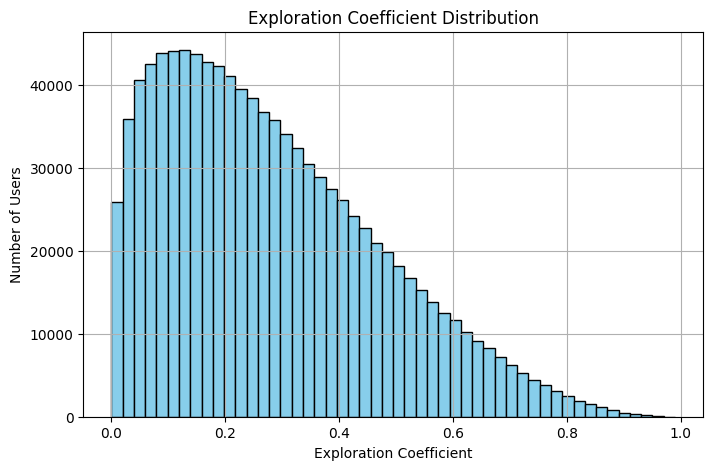

In [ ]:
# Show exploration coefficient statistics
print("\n Exploration Coefficient Statistics:")
print(f"Min: {exploration_coeffs.min():.4f}")
print(f"P1: {np.percentile(exploration_coeffs, 1):.4f}")
print(f"P25: {np.percentile(exploration_coeffs, 25):.4f}")
print(f"Median: {np.median(exploration_coeffs):.4f}")
print(f"Mean: {np.mean(exploration_coeffs):.4f}")
print(f"P75: {np.percentile(exploration_coeffs, 75):.4f}")
print(f"P99: {np.percentile(exploration_coeffs, 99):.4f}")
print(f"Max: {exploration_coeffs.max():.4f}")

# Plot exploration coefficient distribution
plt.figure(figsize=(8, 5))
plt.hist(exploration_coeffs, bins=50, color='skyblue', edgecolor='black')
plt.title("Exploration Coefficient Distribution")
plt.xlabel("Exploration Coefficient")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

In [ ]:
# Explore parquet files that have user, playlist, and number of song matches between both

import pandas as pd
import os


# Path to your input directory
input_dir = "/content/drive/My Drive/datasets/overlap_processed"

# List available parquet files
parquet_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".parquet"))
print(f"Found {len(parquet_files)} files. Example file: {parquet_files[0]}")

# Load one file
sample_file = os.path.join(input_dir, parquet_files[0])
df = pd.read_parquet(sample_file)

# Show column names
print("\nüìã Columns in sample parquet slice:")
print(df.columns.tolist())

# Show a few rows
print("\nüîé First few rows:")
print(df.head())

Found 102 files. Example file: overlap_0_10000.parquet

üìã Columns in sample parquet slice:
['user_id', 'playlist_id', 'song_count']

üîé First few rows:
   user_id  playlist_id  song_count
0        0       910083           1
1        0       881762           1
2        0       640163           1
3        0       579309           1
4        0       568368           1


### Now we actually calculate the scores for all user-playlists

In [ ]:
import os
import pickle
import polars as pl
from tqdm import tqdm

# === Paths ===
input_dir = "/content/drive/My Drive/datasets/overlap_processed_fixed"  # Overlap slices
output_dir = "/content/drive/My Drive/datasets/userplaylist_score_slices_fixed"  # Scored slices
os.makedirs(output_dir, exist_ok=True)

# === Load mappings ===
idx_to_user_df = pl.read_parquet("/content/drive/My Drive/datasets/idx_to_user.parquet")
idx_to_playlist_df = pl.read_parquet("/content/drive/My Drive/datasets/idx_to_playlist.parquet")

idx_to_playlist = dict(zip(idx_to_playlist_df["playlist_idx"].to_numpy(), idx_to_playlist_df["playlist_id"].to_numpy()))

# Load user and playlist song counts
user_song_counts = pl.read_parquet("/content/drive/My Drive/datasets/user_song_counts_idx.parquet")
playlist_song_counts = pl.read_parquet("/content/drive/My Drive/datasets/playlist_song_counts_idx.parquet")

user_song_map = dict(zip(user_song_counts["user_idx"].to_numpy(), user_song_counts["song_count"].to_numpy()))
playlist_song_map = dict(zip(playlist_song_counts["playlist_idx"].to_numpy(), playlist_song_counts["song_count"].to_numpy()))

# Load exploration coefficients
with open("/content/drive/My Drive/datasets/exploration_map.pkl", "rb") as f:
    exploration_map = pickle.load(f)

# === Start processing slices ===
parquet_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".parquet"))

for file_name in tqdm(parquet_files, desc="Processing slices (Polars Version)"):
    path = os.path.join(input_dir, file_name)

    # Read the slice
    df = pl.read_parquet(path)

    # Rename column
    df = df.rename({"song_count": "match_count"})

    # Filter match_count > 0
    df = df.filter(pl.col("match_count") > 0)

    # Assume user_id is already user_idx
    df = df.with_columns([
        pl.col("user_id").alias("user_idx"),
        pl.col("playlist_id").alias("playlist_idx")
    ])

    # Map playlist_id ‚Üí real_playlist_id, and add user/song counts and exploration coefficient
    # Create mapping DataFrames
    idx_to_playlist_df = pl.DataFrame({
        "playlist_idx": list(idx_to_playlist.keys()),
        "real_playlist_id": list(idx_to_playlist.values())
    })

    user_song_map_df = pl.DataFrame({
        "user_idx": list(user_song_map.keys()),
        "s": list(user_song_map.values())
    })

    playlist_song_map_df = pl.DataFrame({
        "playlist_idx": list(playlist_song_map.keys()),
        "p": list(playlist_song_map.values())
    })

    exploration_map_df = pl.DataFrame({
        "user_idx": list(exploration_map.keys()),
        "e": list(exploration_map.values())
    })

    # Merge metadata via fast joins
    df = df.join(idx_to_playlist_df, on="playlist_idx", how="left")
    df = df.join(user_song_map_df, on="user_idx", how="left")
    df = df.join(playlist_song_map_df, on="playlist_idx", how="left")
    df = df.join(exploration_map_df, on="user_idx", how="left")

    # Drop missing mappings
    df = df.drop_nulls(subset=["real_playlist_id", "s", "p", "e"])

    # Compute score
    df = df.with_columns([
        (
            ((1 - pl.col("e")) * (pl.col("match_count") + 1).log() + pl.col("e"))
            / (pl.col("s").sqrt() * pl.col("p").sqrt())
        ).alias("score")
    ])

    # Print some stats
    print(f"‚úÖ Median score of {file_name}: {df['score'].median():.4f}")
    print(f"‚úÖ Min score of {file_name}: {df['score'].min():.4f}")
    print(f"‚úÖ Max score of {file_name}: {df['score'].max():.4f}")

    # Save only the needed columns
    output_path = os.path.join(output_dir, f"scored_{file_name}")
    df.select(["user_idx", "playlist_idx", "match_count", "score"]).write_parquet(output_path)

print("\n‚úÖ‚úÖ All slices processed and scores saved to:", output_dir)

üßÆ Processing slices (Polars Version):   0%|          | 0/102 [00:00<?, ?it/s]

‚úÖ Median score of overlap_0_10000.parquet: 0.0125
‚úÖ Min score of overlap_0_10000.parquet: 0.0012
‚úÖ Max score of overlap_0_10000.parquet: 0.4773


üßÆ Processing slices (Polars Version):   1%|          | 1/102 [02:19<3:54:25, 139.27s/it]

‚úÖ Median score of overlap_1000000_1010000.parquet: 0.0125
‚úÖ Min score of overlap_1000000_1010000.parquet: 0.0013
‚úÖ Max score of overlap_1000000_1010000.parquet: 0.3854


üßÆ Processing slices (Polars Version):   2%|‚ñè         | 2/102 [04:51<4:04:52, 146.93s/it]

‚úÖ Median score of overlap_100000_110000.parquet: 0.0125
‚úÖ Min score of overlap_100000_110000.parquet: 0.0016
‚úÖ Max score of overlap_100000_110000.parquet: 0.4255


üßÆ Processing slices (Polars Version):   3%|‚ñé         | 3/102 [06:54<3:44:38, 136.15s/it]

‚úÖ Median score of overlap_10000_20000.parquet: 0.0124
‚úÖ Min score of overlap_10000_20000.parquet: 0.0014
‚úÖ Max score of overlap_10000_20000.parquet: 0.3654


üßÆ Processing slices (Polars Version):   4%|‚ñç         | 4/102 [09:05<3:38:55, 134.04s/it]

‚úÖ Median score of overlap_1010000_1019318.parquet: 0.0126
‚úÖ Min score of overlap_1010000_1019318.parquet: 0.0015
‚úÖ Max score of overlap_1010000_1019318.parquet: 0.3757


üßÆ Processing slices (Polars Version):   5%|‚ñç         | 5/102 [11:00<3:25:28, 127.10s/it]

‚úÖ Median score of overlap_110000_120000.parquet: 0.0125
‚úÖ Min score of overlap_110000_120000.parquet: 0.0016
‚úÖ Max score of overlap_110000_120000.parquet: 0.3625


üßÆ Processing slices (Polars Version):   6%|‚ñå         | 6/102 [13:19<3:29:44, 131.09s/it]

‚úÖ Median score of overlap_120000_130000.parquet: 0.0123
‚úÖ Min score of overlap_120000_130000.parquet: 0.0015
‚úÖ Max score of overlap_120000_130000.parquet: 0.3578


üßÆ Processing slices (Polars Version):   7%|‚ñã         | 7/102 [15:19<3:22:06, 127.65s/it]

‚úÖ Median score of overlap_130000_140000.parquet: 0.0125
‚úÖ Min score of overlap_130000_140000.parquet: 0.0015
‚úÖ Max score of overlap_130000_140000.parquet: 0.3612


üßÆ Processing slices (Polars Version):   8%|‚ñä         | 8/102 [17:33<3:23:07, 129.65s/it]

‚úÖ Median score of overlap_140000_150000.parquet: 0.0126
‚úÖ Min score of overlap_140000_150000.parquet: 0.0015
‚úÖ Max score of overlap_140000_150000.parquet: 0.3664


üßÆ Processing slices (Polars Version):   9%|‚ñâ         | 9/102 [19:30<3:14:28, 125.47s/it]

‚úÖ Median score of overlap_150000_160000.parquet: 0.0125
‚úÖ Min score of overlap_150000_160000.parquet: 0.0016
‚úÖ Max score of overlap_150000_160000.parquet: 0.4078


üßÆ Processing slices (Polars Version):  10%|‚ñâ         | 10/102 [21:33<3:11:14, 124.73s/it]

‚úÖ Median score of overlap_160000_170000.parquet: 0.0125
‚úÖ Min score of overlap_160000_170000.parquet: 0.0013
‚úÖ Max score of overlap_160000_170000.parquet: 0.4663


üßÆ Processing slices (Polars Version):  11%|‚ñà         | 11/102 [23:36<3:08:38, 124.37s/it]

‚úÖ Median score of overlap_170000_180000.parquet: 0.0125
‚úÖ Min score of overlap_170000_180000.parquet: 0.0015
‚úÖ Max score of overlap_170000_180000.parquet: 0.4911


üßÆ Processing slices (Polars Version):  12%|‚ñà‚ñè        | 12/102 [25:37<3:04:52, 123.25s/it]

‚úÖ Median score of overlap_180000_190000.parquet: 0.0124
‚úÖ Min score of overlap_180000_190000.parquet: 0.0017
‚úÖ Max score of overlap_180000_190000.parquet: 0.3936


üßÆ Processing slices (Polars Version):  13%|‚ñà‚ñé        | 13/102 [27:35<3:00:43, 121.84s/it]

‚úÖ Median score of overlap_190000_200000.parquet: 0.0125
‚úÖ Min score of overlap_190000_200000.parquet: 0.0015
‚úÖ Max score of overlap_190000_200000.parquet: 0.4760


üßÆ Processing slices (Polars Version):  14%|‚ñà‚ñé        | 14/102 [29:44<3:01:26, 123.71s/it]

‚úÖ Median score of overlap_200000_210000.parquet: 0.0124
‚úÖ Min score of overlap_200000_210000.parquet: 0.0016
‚úÖ Max score of overlap_200000_210000.parquet: 0.3882


üßÆ Processing slices (Polars Version):  15%|‚ñà‚ñç        | 15/102 [31:48<2:59:48, 124.00s/it]

‚úÖ Median score of overlap_20000_30000.parquet: 0.0127
‚úÖ Min score of overlap_20000_30000.parquet: 0.0018
‚úÖ Max score of overlap_20000_30000.parquet: 0.3302


üßÆ Processing slices (Polars Version):  16%|‚ñà‚ñå        | 16/102 [33:49<2:56:16, 122.98s/it]

‚úÖ Median score of overlap_210000_220000.parquet: 0.0124
‚úÖ Min score of overlap_210000_220000.parquet: 0.0016
‚úÖ Max score of overlap_210000_220000.parquet: 0.3764


üßÆ Processing slices (Polars Version):  17%|‚ñà‚ñã        | 17/102 [35:57<2:56:21, 124.49s/it]

‚úÖ Median score of overlap_220000_230000.parquet: 0.0124
‚úÖ Min score of overlap_220000_230000.parquet: 0.0014
‚úÖ Max score of overlap_220000_230000.parquet: 0.3617


üßÆ Processing slices (Polars Version):  18%|‚ñà‚ñä        | 18/102 [38:04<2:55:13, 125.17s/it]

‚úÖ Median score of overlap_230000_240000.parquet: 0.0124
‚úÖ Min score of overlap_230000_240000.parquet: 0.0013
‚úÖ Max score of overlap_230000_240000.parquet: 0.3540


üßÆ Processing slices (Polars Version):  19%|‚ñà‚ñä        | 19/102 [40:13<2:54:46, 126.34s/it]

‚úÖ Median score of overlap_240000_250000.parquet: 0.0126
‚úÖ Min score of overlap_240000_250000.parquet: 0.0014
‚úÖ Max score of overlap_240000_250000.parquet: 0.4905


üßÆ Processing slices (Polars Version):  20%|‚ñà‚ñâ        | 20/102 [42:42<3:02:03, 133.21s/it]

‚úÖ Median score of overlap_250000_260000.parquet: 0.0124
‚úÖ Min score of overlap_250000_260000.parquet: 0.0015
‚úÖ Max score of overlap_250000_260000.parquet: 0.3653


üßÆ Processing slices (Polars Version):  21%|‚ñà‚ñà        | 21/102 [45:05<3:03:46, 136.13s/it]

‚úÖ Median score of overlap_260000_270000.parquet: 0.0125
‚úÖ Min score of overlap_260000_270000.parquet: 0.0013
‚úÖ Max score of overlap_260000_270000.parquet: 0.3628


üßÆ Processing slices (Polars Version):  22%|‚ñà‚ñà‚ñè       | 22/102 [47:21<3:01:40, 136.26s/it]

‚úÖ Median score of overlap_270000_280000.parquet: 0.0125
‚úÖ Min score of overlap_270000_280000.parquet: 0.0016
‚úÖ Max score of overlap_270000_280000.parquet: 0.3740


üßÆ Processing slices (Polars Version):  23%|‚ñà‚ñà‚ñé       | 23/102 [50:01<3:08:43, 143.34s/it]

‚úÖ Median score of overlap_280000_290000.parquet: 0.0128
‚úÖ Min score of overlap_280000_290000.parquet: 0.0014
‚úÖ Max score of overlap_280000_290000.parquet: 0.3618


üßÆ Processing slices (Polars Version):  24%|‚ñà‚ñà‚ñé       | 24/102 [52:10<3:00:43, 139.01s/it]

‚úÖ Median score of overlap_290000_300000.parquet: 0.0126
‚úÖ Min score of overlap_290000_300000.parquet: 0.0017
‚úÖ Max score of overlap_290000_300000.parquet: 0.4179


üßÆ Processing slices (Polars Version):  25%|‚ñà‚ñà‚ñç       | 25/102 [54:41<3:02:47, 142.43s/it]

‚úÖ Median score of overlap_300000_310000.parquet: 0.0124
‚úÖ Min score of overlap_300000_310000.parquet: 0.0015
‚úÖ Max score of overlap_300000_310000.parquet: 0.3922


üßÆ Processing slices (Polars Version):  25%|‚ñà‚ñà‚ñå       | 26/102 [56:50<2:55:30, 138.56s/it]

‚úÖ Median score of overlap_30000_40000.parquet: 0.0125
‚úÖ Min score of overlap_30000_40000.parquet: 0.0013
‚úÖ Max score of overlap_30000_40000.parquet: 0.3613


üßÆ Processing slices (Polars Version):  26%|‚ñà‚ñà‚ñã       | 27/102 [59:16<2:55:55, 140.73s/it]

‚úÖ Median score of overlap_310000_320000.parquet: 0.0127
‚úÖ Min score of overlap_310000_320000.parquet: 0.0012
‚úÖ Max score of overlap_310000_320000.parquet: 0.3900


üßÆ Processing slices (Polars Version):  27%|‚ñà‚ñà‚ñã       | 28/102 [1:01:47<2:57:34, 143.98s/it]

‚úÖ Median score of overlap_320000_330000.parquet: 0.0126
‚úÖ Min score of overlap_320000_330000.parquet: 0.0015
‚úÖ Max score of overlap_320000_330000.parquet: 0.3823


üßÆ Processing slices (Polars Version):  28%|‚ñà‚ñà‚ñä       | 29/102 [1:03:53<2:48:36, 138.58s/it]

‚úÖ Median score of overlap_330000_340000.parquet: 0.0125
‚úÖ Min score of overlap_330000_340000.parquet: 0.0016
‚úÖ Max score of overlap_330000_340000.parquet: 0.4055


üßÆ Processing slices (Polars Version):  29%|‚ñà‚ñà‚ñâ       | 30/102 [1:06:21<2:49:27, 141.22s/it]

‚úÖ Median score of overlap_340000_350000.parquet: 0.0126
‚úÖ Min score of overlap_340000_350000.parquet: 0.0015
‚úÖ Max score of overlap_340000_350000.parquet: 0.3625


üßÆ Processing slices (Polars Version):  30%|‚ñà‚ñà‚ñà       | 31/102 [1:08:45<2:48:04, 142.03s/it]

‚úÖ Median score of overlap_350000_360000.parquet: 0.0126
‚úÖ Min score of overlap_350000_360000.parquet: 0.0014
‚úÖ Max score of overlap_350000_360000.parquet: 0.3774


üßÆ Processing slices (Polars Version):  31%|‚ñà‚ñà‚ñà‚ñè      | 32/102 [1:10:53<2:40:50, 137.87s/it]

‚úÖ Median score of overlap_360000_370000.parquet: 0.0125
‚úÖ Min score of overlap_360000_370000.parquet: 0.0016
‚úÖ Max score of overlap_360000_370000.parquet: 0.3856


üßÆ Processing slices (Polars Version):  32%|‚ñà‚ñà‚ñà‚ñè      | 33/102 [1:13:08<2:37:39, 137.09s/it]

‚úÖ Median score of overlap_370000_380000.parquet: 0.0125
‚úÖ Min score of overlap_370000_380000.parquet: 0.0016
‚úÖ Max score of overlap_370000_380000.parquet: 0.4007


üßÆ Processing slices (Polars Version):  33%|‚ñà‚ñà‚ñà‚ñé      | 34/102 [1:15:27<2:35:51, 137.53s/it]

‚úÖ Median score of overlap_380000_390000.parquet: 0.0127
‚úÖ Min score of overlap_380000_390000.parquet: 0.0016
‚úÖ Max score of overlap_380000_390000.parquet: 0.3988


üßÆ Processing slices (Polars Version):  34%|‚ñà‚ñà‚ñà‚ñç      | 35/102 [1:17:29<2:28:20, 132.84s/it]

‚úÖ Median score of overlap_390000_400000.parquet: 0.0126
‚úÖ Min score of overlap_390000_400000.parquet: 0.0013
‚úÖ Max score of overlap_390000_400000.parquet: 0.3587


üßÆ Processing slices (Polars Version):  35%|‚ñà‚ñà‚ñà‚ñå      | 36/102 [1:19:39<2:25:12, 132.01s/it]

‚úÖ Median score of overlap_400000_410000.parquet: 0.0126
‚úÖ Min score of overlap_400000_410000.parquet: 0.0012
‚úÖ Max score of overlap_400000_410000.parquet: 0.3495


üßÆ Processing slices (Polars Version):  36%|‚ñà‚ñà‚ñà‚ñã      | 37/102 [1:22:11<2:29:43, 138.21s/it]

‚úÖ Median score of overlap_40000_50000.parquet: 0.0124
‚úÖ Min score of overlap_40000_50000.parquet: 0.0015
‚úÖ Max score of overlap_40000_50000.parquet: 0.3805


üßÆ Processing slices (Polars Version):  37%|‚ñà‚ñà‚ñà‚ñã      | 38/102 [1:24:40<2:30:48, 141.38s/it]

‚úÖ Median score of overlap_410000_420000.parquet: 0.0126
‚úÖ Min score of overlap_410000_420000.parquet: 0.0015
‚úÖ Max score of overlap_410000_420000.parquet: 0.5437


üßÆ Processing slices (Polars Version):  38%|‚ñà‚ñà‚ñà‚ñä      | 39/102 [1:26:45<2:23:10, 136.36s/it]

‚úÖ Median score of overlap_420000_430000.parquet: 0.0126
‚úÖ Min score of overlap_420000_430000.parquet: 0.0017
‚úÖ Max score of overlap_420000_430000.parquet: 0.3708


üßÆ Processing slices (Polars Version):  39%|‚ñà‚ñà‚ñà‚ñâ      | 40/102 [1:29:05<2:22:03, 137.47s/it]

‚úÖ Median score of overlap_430000_440000.parquet: 0.0126
‚úÖ Min score of overlap_430000_440000.parquet: 0.0017
‚úÖ Max score of overlap_430000_440000.parquet: 0.3877


üßÆ Processing slices (Polars Version):  40%|‚ñà‚ñà‚ñà‚ñà      | 41/102 [1:31:10<2:16:08, 133.91s/it]

‚úÖ Median score of overlap_440000_450000.parquet: 0.0126
‚úÖ Min score of overlap_440000_450000.parquet: 0.0014
‚úÖ Max score of overlap_440000_450000.parquet: 0.3730


üßÆ Processing slices (Polars Version):  41%|‚ñà‚ñà‚ñà‚ñà      | 42/102 [1:32:58<2:05:59, 125.98s/it]

‚úÖ Median score of overlap_450000_460000.parquet: 0.0126
‚úÖ Min score of overlap_450000_460000.parquet: 0.0019
‚úÖ Max score of overlap_450000_460000.parquet: 0.3626


üßÆ Processing slices (Polars Version):  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 43/102 [1:34:55<2:01:08, 123.19s/it]

‚úÖ Median score of overlap_460000_470000.parquet: 0.0126
‚úÖ Min score of overlap_460000_470000.parquet: 0.0013
‚úÖ Max score of overlap_460000_470000.parquet: 0.3907


üßÆ Processing slices (Polars Version):  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 44/102 [1:37:15<2:03:59, 128.26s/it]

‚úÖ Median score of overlap_470000_480000.parquet: 0.0126
‚úÖ Min score of overlap_470000_480000.parquet: 0.0016
‚úÖ Max score of overlap_470000_480000.parquet: 0.3792


üßÆ Processing slices (Polars Version):  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 45/102 [1:39:12<1:58:49, 125.07s/it]

‚úÖ Median score of overlap_480000_490000.parquet: 0.0126
‚úÖ Min score of overlap_480000_490000.parquet: 0.0017
‚úÖ Max score of overlap_480000_490000.parquet: 0.3989


üßÆ Processing slices (Polars Version):  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 46/102 [1:41:02<1:52:24, 120.44s/it]

‚úÖ Median score of overlap_490000_500000.parquet: 0.0127
‚úÖ Min score of overlap_490000_500000.parquet: 0.0014
‚úÖ Max score of overlap_490000_500000.parquet: 0.3709


üßÆ Processing slices (Polars Version):  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 47/102 [1:42:47<1:46:09, 115.80s/it]

‚úÖ Median score of overlap_500000_510000.parquet: 0.0126
‚úÖ Min score of overlap_500000_510000.parquet: 0.0013
‚úÖ Max score of overlap_500000_510000.parquet: 0.3735


üßÆ Processing slices (Polars Version):  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 48/102 [1:45:05<1:50:11, 122.44s/it]

‚úÖ Median score of overlap_50000_60000.parquet: 0.0125
‚úÖ Min score of overlap_50000_60000.parquet: 0.0014
‚úÖ Max score of overlap_50000_60000.parquet: 0.4131


üßÆ Processing slices (Polars Version):  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 49/102 [1:47:23<1:52:25, 127.27s/it]

‚úÖ Median score of overlap_510000_520000.parquet: 0.0124
‚úÖ Min score of overlap_510000_520000.parquet: 0.0015
‚úÖ Max score of overlap_510000_520000.parquet: 0.4690


üßÆ Processing slices (Polars Version):  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 50/102 [1:49:34<1:51:07, 128.21s/it]

‚úÖ Median score of overlap_520000_530000.parquet: 0.0126
‚úÖ Min score of overlap_520000_530000.parquet: 0.0018
‚úÖ Max score of overlap_520000_530000.parquet: 0.4657


üßÆ Processing slices (Polars Version):  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 51/102 [1:51:35<1:47:12, 126.13s/it]

‚úÖ Median score of overlap_530000_540000.parquet: 0.0124
‚úÖ Min score of overlap_530000_540000.parquet: 0.0015
‚úÖ Max score of overlap_530000_540000.parquet: 0.3856


üßÆ Processing slices (Polars Version):  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 52/102 [1:53:43<1:45:28, 126.58s/it]

‚úÖ Median score of overlap_540000_550000.parquet: 0.0124
‚úÖ Min score of overlap_540000_550000.parquet: 0.0014
‚úÖ Max score of overlap_540000_550000.parquet: 0.3500


üßÆ Processing slices (Polars Version):  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 53/102 [1:56:00<1:45:57, 129.75s/it]

‚úÖ Median score of overlap_550000_560000.parquet: 0.0123
‚úÖ Min score of overlap_550000_560000.parquet: 0.0017
‚úÖ Max score of overlap_550000_560000.parquet: 0.3449


üßÆ Processing slices (Polars Version):  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 54/102 [1:58:14<1:44:45, 130.94s/it]

‚úÖ Median score of overlap_560000_570000.parquet: 0.0124
‚úÖ Min score of overlap_560000_570000.parquet: 0.0018
‚úÖ Max score of overlap_560000_570000.parquet: 0.4544


üßÆ Processing slices (Polars Version):  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 55/102 [2:00:24<1:42:20, 130.65s/it]

‚úÖ Median score of overlap_570000_580000.parquet: 0.0125
‚úÖ Min score of overlap_570000_580000.parquet: 0.0015
‚úÖ Max score of overlap_570000_580000.parquet: 0.3773


üßÆ Processing slices (Polars Version):  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 56/102 [2:02:13<1:35:18, 124.32s/it]

‚úÖ Median score of overlap_580000_590000.parquet: 0.0125
‚úÖ Min score of overlap_580000_590000.parquet: 0.0015
‚úÖ Max score of overlap_580000_590000.parquet: 0.3495


üßÆ Processing slices (Polars Version):  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 57/102 [2:04:27<1:35:27, 127.28s/it]

‚úÖ Median score of overlap_590000_600000.parquet: 0.0124
‚úÖ Min score of overlap_590000_600000.parquet: 0.0016
‚úÖ Max score of overlap_590000_600000.parquet: 0.4216


üßÆ Processing slices (Polars Version):  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 58/102 [2:06:30<1:32:23, 125.98s/it]

‚úÖ Median score of overlap_600000_610000.parquet: 0.0124
‚úÖ Min score of overlap_600000_610000.parquet: 0.0014
‚úÖ Max score of overlap_600000_610000.parquet: 0.3440


üßÆ Processing slices (Polars Version):  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 59/102 [2:08:28<1:28:34, 123.58s/it]

‚úÖ Median score of overlap_60000_70000.parquet: 0.0125
‚úÖ Min score of overlap_60000_70000.parquet: 0.0015
‚úÖ Max score of overlap_60000_70000.parquet: 0.4397


üßÆ Processing slices (Polars Version):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 60/102 [2:10:36<1:27:22, 124.83s/it]

‚úÖ Median score of overlap_610000_620000.parquet: 0.0123
‚úÖ Min score of overlap_610000_620000.parquet: 0.0013
‚úÖ Max score of overlap_610000_620000.parquet: 0.3644


üßÆ Processing slices (Polars Version):  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 61/102 [2:12:42<1:25:33, 125.21s/it]

‚úÖ Median score of overlap_620000_630000.parquet: 0.0126
‚úÖ Min score of overlap_620000_630000.parquet: 0.0015
‚úÖ Max score of overlap_620000_630000.parquet: 0.3778


üßÆ Processing slices (Polars Version):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 62/102 [2:14:37<1:21:26, 122.16s/it]

‚úÖ Median score of overlap_630000_640000.parquet: 0.0126
‚úÖ Min score of overlap_630000_640000.parquet: 0.0007
‚úÖ Max score of overlap_630000_640000.parquet: 0.3718


üßÆ Processing slices (Polars Version):  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 63/102 [2:16:35<1:18:32, 120.82s/it]

‚úÖ Median score of overlap_640000_650000.parquet: 0.0124
‚úÖ Min score of overlap_640000_650000.parquet: 0.0016
‚úÖ Max score of overlap_640000_650000.parquet: 0.3628


üßÆ Processing slices (Polars Version):  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 64/102 [2:18:56<1:20:29, 127.08s/it]

‚úÖ Median score of overlap_650000_660000.parquet: 0.0122
‚úÖ Min score of overlap_650000_660000.parquet: 0.0016
‚úÖ Max score of overlap_650000_660000.parquet: 0.3992


üßÆ Processing slices (Polars Version):  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 65/102 [2:21:34<1:23:56, 136.12s/it]

‚úÖ Median score of overlap_660000_670000.parquet: 0.0125
‚úÖ Min score of overlap_660000_670000.parquet: 0.0014
‚úÖ Max score of overlap_660000_670000.parquet: 0.3388


üßÆ Processing slices (Polars Version):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 66/102 [2:23:51<1:21:49, 136.38s/it]

‚úÖ Median score of overlap_670000_680000.parquet: 0.0123
‚úÖ Min score of overlap_670000_680000.parquet: 0.0015
‚úÖ Max score of overlap_670000_680000.parquet: 0.3755


üßÆ Processing slices (Polars Version):  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 67/102 [2:26:22<1:22:11, 140.90s/it]

‚úÖ Median score of overlap_680000_690000.parquet: 0.0127
‚úÖ Min score of overlap_680000_690000.parquet: 0.0017
‚úÖ Max score of overlap_680000_690000.parquet: 0.3850


üßÆ Processing slices (Polars Version):  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 68/102 [2:28:18<1:15:36, 133.42s/it]

‚úÖ Median score of overlap_690000_700000.parquet: 0.0126
‚úÖ Min score of overlap_690000_700000.parquet: 0.0014
‚úÖ Max score of overlap_690000_700000.parquet: 0.3591


üßÆ Processing slices (Polars Version):  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 69/102 [2:30:28<1:12:51, 132.48s/it]

‚úÖ Median score of overlap_700000_710000.parquet: 0.0126
‚úÖ Min score of overlap_700000_710000.parquet: 0.0017
‚úÖ Max score of overlap_700000_710000.parquet: 0.3666


üßÆ Processing slices (Polars Version):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 70/102 [2:32:24<1:07:55, 127.35s/it]

‚úÖ Median score of overlap_70000_80000.parquet: 0.0123
‚úÖ Min score of overlap_70000_80000.parquet: 0.0015
‚úÖ Max score of overlap_70000_80000.parquet: 0.3774


üßÆ Processing slices (Polars Version):  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 71/102 [2:34:36<1:06:33, 128.83s/it]

‚úÖ Median score of overlap_710000_720000.parquet: 0.0126
‚úÖ Min score of overlap_710000_720000.parquet: 0.0016
‚úÖ Max score of overlap_710000_720000.parquet: 0.4475


üßÆ Processing slices (Polars Version):  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 72/102 [2:36:36<1:03:05, 126.20s/it]

‚úÖ Median score of overlap_720000_730000.parquet: 0.0125
‚úÖ Min score of overlap_720000_730000.parquet: 0.0017
‚úÖ Max score of overlap_720000_730000.parquet: 0.3936


üßÆ Processing slices (Polars Version):  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 73/102 [2:38:37<1:00:11, 124.55s/it]

‚úÖ Median score of overlap_730000_740000.parquet: 0.0124
‚úÖ Min score of overlap_730000_740000.parquet: 0.0016
‚úÖ Max score of overlap_730000_740000.parquet: 0.3890


üßÆ Processing slices (Polars Version):  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 74/102 [2:40:27<56:04, 120.17s/it]  

‚úÖ Median score of overlap_740000_750000.parquet: 0.0126
‚úÖ Min score of overlap_740000_750000.parquet: 0.0018
‚úÖ Max score of overlap_740000_750000.parquet: 0.4315


üßÆ Processing slices (Polars Version):  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 75/102 [2:42:40<55:51, 124.13s/it]

‚úÖ Median score of overlap_750000_760000.parquet: 0.0125
‚úÖ Min score of overlap_750000_760000.parquet: 0.0015
‚úÖ Max score of overlap_750000_760000.parquet: 0.3855


üßÆ Processing slices (Polars Version):  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 76/102 [2:44:33<52:23, 120.89s/it]

‚úÖ Median score of overlap_760000_770000.parquet: 0.0124
‚úÖ Min score of overlap_760000_770000.parquet: 0.0015
‚úÖ Max score of overlap_760000_770000.parquet: 0.3751


üßÆ Processing slices (Polars Version):  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 77/102 [2:46:49<52:11, 125.25s/it]

‚úÖ Median score of overlap_770000_780000.parquet: 0.0125
‚úÖ Min score of overlap_770000_780000.parquet: 0.0014
‚úÖ Max score of overlap_770000_780000.parquet: 0.3348


üßÆ Processing slices (Polars Version):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 78/102 [2:48:50<49:34, 123.93s/it]

‚úÖ Median score of overlap_780000_790000.parquet: 0.0125
‚úÖ Min score of overlap_780000_790000.parquet: 0.0011
‚úÖ Max score of overlap_780000_790000.parquet: 0.3762


üßÆ Processing slices (Polars Version):  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 79/102 [2:50:48<46:51, 122.24s/it]

‚úÖ Median score of overlap_790000_800000.parquet: 0.0125
‚úÖ Min score of overlap_790000_800000.parquet: 0.0015
‚úÖ Max score of overlap_790000_800000.parquet: 0.3968


üßÆ Processing slices (Polars Version):  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 80/102 [2:52:59<45:49, 124.96s/it]

‚úÖ Median score of overlap_800000_810000.parquet: 0.0125
‚úÖ Min score of overlap_800000_810000.parquet: 0.0014
‚úÖ Max score of overlap_800000_810000.parquet: 0.3737


üßÆ Processing slices (Polars Version):  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 81/102 [2:54:59<43:08, 123.25s/it]

‚úÖ Median score of overlap_80000_90000.parquet: 0.0125
‚úÖ Min score of overlap_80000_90000.parquet: 0.0013
‚úÖ Max score of overlap_80000_90000.parquet: 0.3696


üßÆ Processing slices (Polars Version):  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 82/102 [2:56:49<39:46, 119.33s/it]

‚úÖ Median score of overlap_810000_820000.parquet: 0.0125
‚úÖ Min score of overlap_810000_820000.parquet: 0.0016
‚úÖ Max score of overlap_810000_820000.parquet: 0.3353


üßÆ Processing slices (Polars Version):  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 83/102 [2:58:38<36:47, 116.17s/it]

‚úÖ Median score of overlap_820000_830000.parquet: 0.0124
‚úÖ Min score of overlap_820000_830000.parquet: 0.0014
‚úÖ Max score of overlap_820000_830000.parquet: 0.3904


üßÆ Processing slices (Polars Version):  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 84/102 [3:00:45<35:52, 119.59s/it]

‚úÖ Median score of overlap_830000_840000.parquet: 0.0125
‚úÖ Min score of overlap_830000_840000.parquet: 0.0015
‚úÖ Max score of overlap_830000_840000.parquet: 0.3809


üßÆ Processing slices (Polars Version):  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 85/102 [3:02:50<34:21, 121.25s/it]

‚úÖ Median score of overlap_840000_850000.parquet: 0.0124
‚úÖ Min score of overlap_840000_850000.parquet: 0.0014
‚úÖ Max score of overlap_840000_850000.parquet: 0.3974


üßÆ Processing slices (Polars Version):  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 86/102 [3:04:49<32:06, 120.43s/it]

‚úÖ Median score of overlap_850000_860000.parquet: 0.0126
‚úÖ Min score of overlap_850000_860000.parquet: 0.0014
‚úÖ Max score of overlap_850000_860000.parquet: 0.3462


üßÆ Processing slices (Polars Version):  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 87/102 [3:06:37<29:12, 116.82s/it]

‚úÖ Median score of overlap_860000_870000.parquet: 0.0126
‚úÖ Min score of overlap_860000_870000.parquet: 0.0016
‚úÖ Max score of overlap_860000_870000.parquet: 0.3745


üßÆ Processing slices (Polars Version):  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 88/102 [3:08:20<26:17, 112.68s/it]

‚úÖ Median score of overlap_870000_880000.parquet: 0.0127
‚úÖ Min score of overlap_870000_880000.parquet: 0.0019
‚úÖ Max score of overlap_870000_880000.parquet: 0.3736


üßÆ Processing slices (Polars Version):  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 89/102 [3:10:23<25:06, 115.86s/it]

‚úÖ Median score of overlap_880000_890000.parquet: 0.0125
‚úÖ Min score of overlap_880000_890000.parquet: 0.0016
‚úÖ Max score of overlap_880000_890000.parquet: 0.3294


üßÆ Processing slices (Polars Version):  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 90/102 [3:12:30<23:49, 119.14s/it]

‚úÖ Median score of overlap_890000_900000.parquet: 0.0126
‚úÖ Min score of overlap_890000_900000.parquet: 0.0016
‚úÖ Max score of overlap_890000_900000.parquet: 0.3740


üßÆ Processing slices (Polars Version):  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 91/102 [3:14:23<21:31, 117.36s/it]

‚úÖ Median score of overlap_900000_910000.parquet: 0.0125
‚úÖ Min score of overlap_900000_910000.parquet: 0.0015
‚úÖ Max score of overlap_900000_910000.parquet: 0.3930


üßÆ Processing slices (Polars Version):  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 92/102 [3:16:32<20:07, 120.73s/it]

‚úÖ Median score of overlap_90000_100000.parquet: 0.0126
‚úÖ Min score of overlap_90000_100000.parquet: 0.0016
‚úÖ Max score of overlap_90000_100000.parquet: 0.3984


üßÆ Processing slices (Polars Version):  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 93/102 [3:18:33<18:07, 120.79s/it]

‚úÖ Median score of overlap_910000_920000.parquet: 0.0126
‚úÖ Min score of overlap_910000_920000.parquet: 0.0013
‚úÖ Max score of overlap_910000_920000.parquet: 0.3798


üßÆ Processing slices (Polars Version):  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 94/102 [3:20:26<15:48, 118.53s/it]

‚úÖ Median score of overlap_920000_930000.parquet: 0.0126
‚úÖ Min score of overlap_920000_930000.parquet: 0.0014
‚úÖ Max score of overlap_920000_930000.parquet: 0.3905


üßÆ Processing slices (Polars Version):  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 95/102 [3:22:57<14:58, 128.31s/it]

‚úÖ Median score of overlap_930000_940000.parquet: 0.0127
‚úÖ Min score of overlap_930000_940000.parquet: 0.0014
‚úÖ Max score of overlap_930000_940000.parquet: 0.3429


üßÆ Processing slices (Polars Version):  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 96/102 [3:25:08<12:53, 128.86s/it]

‚úÖ Median score of overlap_940000_950000.parquet: 0.0127
‚úÖ Min score of overlap_940000_950000.parquet: 0.0017
‚úÖ Max score of overlap_940000_950000.parquet: 0.4232


üßÆ Processing slices (Polars Version):  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 97/102 [3:27:28<11:01, 132.36s/it]

‚úÖ Median score of overlap_950000_960000.parquet: 0.0124
‚úÖ Min score of overlap_950000_960000.parquet: 0.0016
‚úÖ Max score of overlap_950000_960000.parquet: 0.3888


üßÆ Processing slices (Polars Version):  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 98/102 [3:29:51<09:01, 135.43s/it]

‚úÖ Median score of overlap_960000_970000.parquet: 0.0125
‚úÖ Min score of overlap_960000_970000.parquet: 0.0016
‚úÖ Max score of overlap_960000_970000.parquet: 0.5390


üßÆ Processing slices (Polars Version):  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 99/102 [3:32:07<06:47, 135.72s/it]

‚úÖ Median score of overlap_970000_980000.parquet: 0.0126
‚úÖ Min score of overlap_970000_980000.parquet: 0.0018
‚úÖ Max score of overlap_970000_980000.parquet: 0.3745


üßÆ Processing slices (Polars Version):  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 100/102 [3:34:17<04:27, 133.88s/it]

‚úÖ Median score of overlap_980000_990000.parquet: 0.0124
‚úÖ Min score of overlap_980000_990000.parquet: 0.0016
‚úÖ Max score of overlap_980000_990000.parquet: 0.3327


üßÆ Processing slices (Polars Version):  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 101/102 [3:36:14<02:08, 128.92s/it]

‚úÖ Median score of overlap_990000_1000000.parquet: 0.0126
‚úÖ Min score of overlap_990000_1000000.parquet: 0.0011
‚úÖ Max score of overlap_990000_1000000.parquet: 0.3859


üßÆ Processing slices (Polars Version): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [3:38:35<00:00, 128.58s/it]


‚úÖ‚úÖ All slices processed and scores saved to: /content/drive/My Drive/datasets/userplaylist_score_slices_fixed


# Part 5) Now that we have scores for each user-playlist combination, we will rank them

For this, we will take the 1.5% higher scores for each user and label them as '1'. Meaning that the user, given this playlist as a recommendation, would like the playlist (these are our true labels).

‚úÖ Loaded scored_overlap_0_10000.parquet: 223192860 rows, 4 columns
‚úÖ Labeled slice shape: (223192860, 4)

üìä Statistics for Slice:
Total users: 9984
Total rows: 223192860
Positive (liked) playlists: 3352842 (1.50%)
Negative (non-liked) playlists: 219840018 (98.50%)
Average playlists liked per user: 335.82
Median playlists liked per user: 199.00
Min playlists liked per user: 1.00
Max playlists liked per user: 4339.00


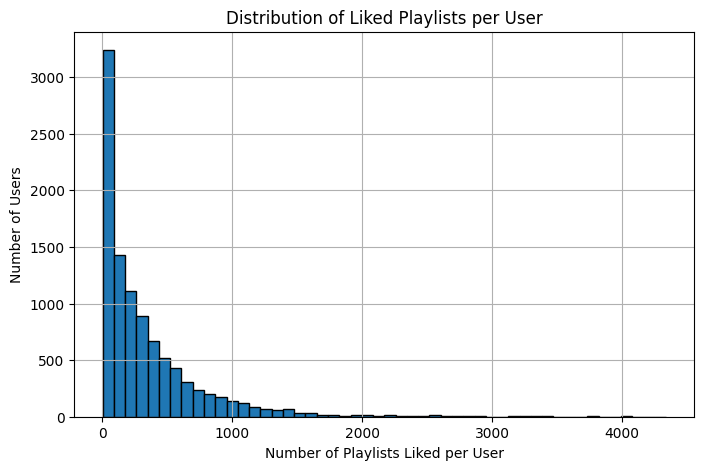


‚úÖ Labeled slice saved to: /content/drive/My Drive/datasets/userplaylist_labeled_slices_fixed/labeled_scored_overlap_0_10000.parquet


In [ ]:
# First let's test our labelling algorithm with one slice of data

import polars as pl
import matplotlib.pyplot as plt
import os

# === Configuration ===
K_PERCENT = 0.015  # Top K% playlists are considered "liked"

# === Paths ===
input_dir = "/content/drive/My Drive/datasets/userplaylist_score_slices_fixed"
output_dir = "/content/drive/My Drive/datasets/userplaylist_labeled_slices_fixed"
os.makedirs(output_dir, exist_ok=True)

# === Select one slice to test ===
file_name = "scored_overlap_0_10000.parquet"  # Change if needed
path = os.path.join(input_dir, file_name)

# === Load scored slice ===
df = pl.read_parquet(path)

print(f"‚úÖ Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")

# === Step 2: Rank and Label ===

# Sort playlists by user_idx and descending score
df = df.sort(["user_idx", "score"], descending=[False, True])

# Group by user_idx and assign ranks (0,1,2,...)
df = df.group_by("user_idx", maintain_order=True).agg([
    pl.col("playlist_idx"),
    pl.col("score"),
    pl.arange(0, pl.len()).alias("rank")
]).explode(["playlist_idx", "score", "rank"])

# Calculate number of playlists per user
user_counts = df.group_by("user_idx").agg([
    pl.len().alias("total_playlists")
])

# Join total playlists into main df
df = df.join(user_counts, on="user_idx", how="left")

# Calculate top_k per user: ceil(total_playlists * K_PERCENT), with minimum 1
df = df.with_columns([
    pl.when((pl.col("total_playlists") * K_PERCENT).ceil() < 1)
      .then(1)
      .otherwise((pl.col("total_playlists") * K_PERCENT).ceil())
      .alias("top_k")
])

# Label playlists: 1 if rank < top_k, else 0
df = df.with_columns([
    (pl.col("rank") < pl.col("top_k")).cast(pl.Int8).alias("label")
])

# Select final columns
df_labeled = df.select(["user_idx", "playlist_idx", "score", "label"])

print(f"‚úÖ Labeled slice shape: {df_labeled.shape}")

# === Statistics ===
num_users = df_labeled["user_idx"].n_unique()
num_positives = df_labeled.filter(pl.col("label") == 1).shape[0]
num_negatives = df_labeled.filter(pl.col("label") == 0).shape[0]
total_rows = df_labeled.shape[0]

print("\nStatistics for Slice:")
print(f"Total users: {num_users}")
print(f"Total rows: {total_rows}")
print(f"Positive (liked) playlists: {num_positives} ({num_positives / total_rows:.2%})")
print(f"Negative (non-liked) playlists: {num_negatives} ({num_negatives / total_rows:.2%})")

# Average liked playlists per user
liked_per_user = df_labeled.filter(pl.col("label") == 1).group_by("user_idx").len()
avg_likes_per_user = liked_per_user["len"].mean()
median_likes_per_user = liked_per_user["len"].median()
min_likes_per_user = liked_per_user["len"].min()
max_likes_per_user = liked_per_user["len"].max()
print(f"Average playlists liked per user: {avg_likes_per_user:.2f}")
print(f"Median playlists liked per user: {median_likes_per_user:.2f}")
print(f"Min playlists liked per user: {min_likes_per_user:.2f}")
print(f"Max playlists liked per user: {max_likes_per_user:.2f}")

# === Plot distribution: number of playlists each user liked
plt.figure(figsize=(8, 5))
plt.hist(liked_per_user["len"].to_numpy(), bins=50, edgecolor='black')
plt.xlabel("Number of Playlists Liked per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Liked Playlists per User")
plt.grid(True)
plt.show()

# === Save labeled slice
output_path = os.path.join(output_dir, f"labeled_{file_name}")
df_labeled.write_parquet(output_path)

print(f"\n Labeled slice saved to: {output_path}")


In [ ]:
# Code for processing all slices

import polars as pl
import os
from tqdm import tqdm

# === Configuration ===
K_PERCENT = 0.015  # Top K% playlists considered "liked"
BATCH_SIZE = 3    # Number of slices to load into memory at once (depends on RAM)

# === Paths ===
input_dir = "/content/drive/My Drive/datasets/userplaylist_score_slices_fixed"
output_dir = "/content/drive/My Drive/datasets/userplaylist_labeled_slices_fixed"
os.makedirs(output_dir, exist_ok=True)

# === Find already processed files
input_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".parquet"))
output_files = sorted(f for f in os.listdir(output_dir) if f.endswith(".parquet"))

processed_files = set(f.replace("labeled_", "").replace("scored_", "") for f in output_files)
remaining_files = [f for f in input_files if f.replace("scored_", "") not in processed_files]

if processed_files:
    print(f"Resuming: {len(processed_files)} files already completed, {len(remaining_files)} remaining.")
else:
    print(f"Starting fresh: {len(remaining_files)} files to process.")

# === Batch processing
for i in tqdm(range(0, len(remaining_files), BATCH_SIZE), desc="Processing batches"):
    batch_files = remaining_files[i:i+BATCH_SIZE]

    # Load all slices in batch
    batch_dfs = []
    for file_name in batch_files:
        path = os.path.join(input_dir, file_name)
        df = pl.read_parquet(path)
        df = df.sort(["user_idx", "score"], descending=[False, True])

        # Group by user_idx and assign rank
        df = df.group_by("user_idx", maintain_order=True).agg([
            pl.col("playlist_idx"),
            pl.col("score"),
            pl.arange(0, pl.len()).alias("rank")
        ]).explode(["playlist_idx", "score", "rank"])

        # Count playlists per user
        user_counts = df.group_by("user_idx").agg([
            pl.len().alias("total_playlists")
        ])

        # Join total playlists
        df = df.join(user_counts, on="user_idx", how="left")

        # Compute top_k
        df = df.with_columns([
            pl.when((pl.col("total_playlists") * K_PERCENT).ceil() < 1)
              .then(1)
              .otherwise((pl.col("total_playlists") * K_PERCENT).ceil())
              .alias("top_k")
        ])

        # Label playlists
        df = df.with_columns([
            (pl.col("rank") < pl.col("top_k")).cast(pl.Int8).alias("label")
        ])

        # Final selection
        df_labeled = df.select(["user_idx", "playlist_idx", "score", "label"])

        batch_dfs.append((file_name, df_labeled))

    # Save all labeled slices from batch
    for file_name, df_labeled in batch_dfs:
        output_file_name = "labeled_" + file_name
        output_path = os.path.join(output_dir, output_file_name)
        df_labeled.write_parquet(output_path)

    print(f"‚úÖ Batch {i//BATCH_SIZE + 1}: Saved {len(batch_files)} labeled slices.")

print("\n‚úÖ‚úÖ All slices processed and labeled saved to:", output_dir)

üîÅ Resuming: 1 files already completed, 101 remaining.


üßÆ Processing batches:   3%|‚ñé         | 1/34 [02:56<1:37:00, 176.38s/it]

‚úÖ Batch 1: Saved 3 labeled slices.


üßÆ Processing batches:   6%|‚ñå         | 2/34 [05:56<1:35:21, 178.79s/it]

‚úÖ Batch 2: Saved 3 labeled slices.


üßÆ Processing batches:   9%|‚ñâ         | 3/34 [08:41<1:29:08, 172.54s/it]

‚úÖ Batch 3: Saved 3 labeled slices.


üßÆ Processing batches:  12%|‚ñà‚ñè        | 4/34 [12:03<1:32:04, 184.14s/it]

‚úÖ Batch 4: Saved 3 labeled slices.


üßÆ Processing batches:  15%|‚ñà‚ñç        | 5/34 [15:18<1:30:48, 187.87s/it]

‚úÖ Batch 5: Saved 3 labeled slices.


üßÆ Processing batches:  18%|‚ñà‚ñä        | 6/34 [18:16<1:26:05, 184.49s/it]

‚úÖ Batch 6: Saved 3 labeled slices.


üßÆ Processing batches:  21%|‚ñà‚ñà        | 7/34 [21:40<1:25:59, 191.08s/it]

‚úÖ Batch 7: Saved 3 labeled slices.


üßÆ Processing batches:  24%|‚ñà‚ñà‚ñé       | 8/34 [24:32<1:20:03, 184.73s/it]

‚úÖ Batch 8: Saved 3 labeled slices.


üßÆ Processing batches:  26%|‚ñà‚ñà‚ñã       | 9/34 [27:26<1:15:39, 181.58s/it]

‚úÖ Batch 9: Saved 3 labeled slices.


üßÆ Processing batches:  29%|‚ñà‚ñà‚ñâ       | 10/34 [30:06<1:09:58, 174.94s/it]

‚úÖ Batch 10: Saved 3 labeled slices.


üßÆ Processing batches:  32%|‚ñà‚ñà‚ñà‚ñè      | 11/34 [33:23<1:09:38, 181.68s/it]

‚úÖ Batch 11: Saved 3 labeled slices.


üßÆ Processing batches:  35%|‚ñà‚ñà‚ñà‚ñå      | 12/34 [36:15<1:05:27, 178.54s/it]

‚úÖ Batch 12: Saved 3 labeled slices.


üßÆ Processing batches:  38%|‚ñà‚ñà‚ñà‚ñä      | 13/34 [39:33<1:04:35, 184.57s/it]

‚úÖ Batch 13: Saved 3 labeled slices.


üßÆ Processing batches:  41%|‚ñà‚ñà‚ñà‚ñà      | 14/34 [43:05<1:04:14, 192.72s/it]

‚úÖ Batch 14: Saved 3 labeled slices.


üßÆ Processing batches:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 15/34 [45:55<58:52, 185.92s/it]  

‚úÖ Batch 15: Saved 3 labeled slices.


üßÆ Processing batches:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 16/34 [48:37<53:35, 178.66s/it]

‚úÖ Batch 16: Saved 3 labeled slices.


üßÆ Processing batches:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 17/34 [51:29<50:06, 176.84s/it]

‚úÖ Batch 17: Saved 3 labeled slices.


üßÆ Processing batches:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 18/34 [55:05<50:17, 188.57s/it]

‚úÖ Batch 18: Saved 3 labeled slices.


üßÆ Processing batches:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 19/34 [58:06<46:32, 186.14s/it]

‚úÖ Batch 19: Saved 3 labeled slices.


üßÆ Processing batches:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 20/34 [1:01:00<42:36, 182.64s/it]

‚úÖ Batch 20: Saved 3 labeled slices.


üßÆ Processing batches:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 21/34 [1:04:31<41:25, 191.18s/it]

‚úÖ Batch 21: Saved 3 labeled slices.


üßÆ Processing batches:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 22/34 [1:07:26<37:15, 186.29s/it]

‚úÖ Batch 22: Saved 3 labeled slices.


üßÆ Processing batches:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 23/34 [1:10:27<33:53, 184.85s/it]

‚úÖ Batch 23: Saved 3 labeled slices.


üßÆ Processing batches:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 24/34 [1:13:24<30:23, 182.30s/it]

‚úÖ Batch 24: Saved 3 labeled slices.


üßÆ Processing batches:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 25/34 [1:16:20<27:02, 180.31s/it]

‚úÖ Batch 25: Saved 3 labeled slices.


üßÆ Processing batches:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 26/34 [1:19:15<23:50, 178.85s/it]

‚úÖ Batch 26: Saved 3 labeled slices.


üßÆ Processing batches:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 27/34 [1:22:18<21:01, 180.15s/it]

‚úÖ Batch 27: Saved 3 labeled slices.


üßÆ Processing batches:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 28/34 [1:26:06<19:27, 194.57s/it]

‚úÖ Batch 28: Saved 3 labeled slices.


üßÆ Processing batches:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 29/34 [1:29:19<16:09, 193.95s/it]

‚úÖ Batch 29: Saved 3 labeled slices.


üßÆ Processing batches:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 30/34 [1:32:05<12:22, 185.63s/it]

‚úÖ Batch 30: Saved 3 labeled slices.


üßÆ Processing batches:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 31/34 [1:35:37<09:40, 193.42s/it]

‚úÖ Batch 31: Saved 3 labeled slices.


üßÆ Processing batches:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 32/34 [1:38:28<06:13, 186.68s/it]

‚úÖ Batch 32: Saved 3 labeled slices.


üßÆ Processing batches:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 33/34 [1:41:14<03:00, 180.60s/it]

‚úÖ Batch 33: Saved 3 labeled slices.


üßÆ Processing batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 34/34 [1:43:15<00:00, 182.21s/it]

‚úÖ Batch 34: Saved 2 labeled slices.

‚úÖ‚úÖ All slices processed and labeled saved to: /content/drive/My Drive/datasets/userplaylist_labeled_slices_fixed


# Part 6) create final datasets for Training stage

## Tasks:

1) Splits of data: \
  a) Split of new_users: for cold start and post-deployment. We are holding out 5% of users with all of their data.\
  b) Then, with remaining users, we'll split the positives (playlist labeled with '1', meaning 'liked'), in 70%-20%-10% for train-val-test sets.\
\
2) Playlist ownership: we'll give to each user the playlist in which they have the highest scores. Then we iterate to make sure all playlists assigned.


3) Validation dataset: for each positive for each user in the validation set, we source up to 50 negative playlists (not liked, this is different from diskliked). This will be used for evaluation after each epoch.

## Step 0) Downscale the dataset, it's just too large. We'll work with 100k users (about 10% of users)

In [ ]:
import os
import random
import pickle
import polars as pl
from tqdm import tqdm

# === Configuration ===
ORIGINAL_SLICE_DIR = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed"
DOWNSCALED_SLICE_DIR = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled"
SELECTED_USERS_PATH = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled/selected_user_ids.pkl"
RESUME_LOG_PATH = os.path.join(DOWNSCALED_SLICE_DIR, "processed_files_log.pkl")

SLICE_USER_SAMPLE_RATIO = 0.10  # Sample 10% of users per slice
SEED = 42
random.seed(SEED)

os.makedirs(DOWNSCALED_SLICE_DIR, exist_ok=True)

# === Load resume log ===
if os.path.exists(RESUME_LOG_PATH):
    with open(RESUME_LOG_PATH, "rb") as f:
        processed_files = pickle.load(f)
else:
    processed_files = set()

selected_users_global = set()
files = sorted(f for f in os.listdir(ORIGINAL_SLICE_DIR) if f.endswith(".parquet"))

# === Process each slice ===
for f in tqdm(files, desc="Processing slices"):
    if f in processed_files:
        continue

    path = os.path.join(ORIGINAL_SLICE_DIR, f)
    df = pl.read_parquet(path)

    user_ids = df["user_idx"].unique().to_list()
    if not user_ids:
        processed_files.add(f)
        with open(RESUME_LOG_PATH, "wb") as logf:
            pickle.dump(processed_files, logf)
        continue

    sample_size = max(1, int(len(user_ids) * SLICE_USER_SAMPLE_RATIO))
    sampled_users = random.sample(user_ids, sample_size)

    df_downscaled = df.filter(pl.col("user_idx").is_in(sampled_users))
    df_downscaled.write_parquet(os.path.join(DOWNSCALED_SLICE_DIR, f))

    selected_users_global.update(sampled_users)

    processed_files.add(f)
    with open(RESUME_LOG_PATH, "wb") as logf:
        pickle.dump(processed_files, logf)

# === Save selected user IDs for future reference ===
with open(SELECTED_USERS_PATH, "wb") as f:
    pickle.dump(selected_users_global, f)

print("‚úÖ All slices processed and saved.")
print("‚úÖ Selected user IDs saved.")


Processing slices: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [22:55<00:00, 13.48s/it]

‚úÖ All slices processed and saved.
‚úÖ Selected user IDs saved.


Next we need to clean all of the playlists that aren't liked by any of the 100k sampled users (this means that we can't assign ownership for that playlist). Also this saves us some memory and will further speed things up.
This dataset should be based on organic playlists that were created by users. If no users like a playlist, it wasn't 'created' by any of our users, and therefore should not exist in this dataset.

In [ ]:
import os
import pickle
import polars as pl
from tqdm import tqdm

# === Paths ===
DOWNSCALED_SLICE_DIR = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled"
LIKED_PLAYLISTS_PATH = os.path.join(DOWNSCALED_SLICE_DIR, "liked_playlist_ids.pkl")
DROPPED_PLAYLISTS_PATH = os.path.join(DOWNSCALED_SLICE_DIR, "dropped_playlist_ids.pkl")

# === Step 1: First Pass - Collect liked and all playlist IDs ===
liked_playlist_ids = set()
all_playlist_ids = set()

files = sorted(f for f in os.listdir(DOWNSCALED_SLICE_DIR) if f.endswith(".parquet"))
for f in tqdm(files, desc="Scanning slices for liked playlists"):
    df = pl.read_parquet(os.path.join(DOWNSCALED_SLICE_DIR, f))
    all_playlist_ids.update(df["playlist_idx"].unique().to_list())
    liked_df = df.filter(pl.col("label") == 1)
    liked_playlist_ids.update(liked_df["playlist_idx"].unique().to_list())

# === Step 2: Compute dropped playlists ===
dropped_playlist_ids = all_playlist_ids - liked_playlist_ids

# === Step 3: Save the sets ===
with open(LIKED_PLAYLISTS_PATH, "wb") as f:
    pickle.dump(liked_playlist_ids, f)
with open(DROPPED_PLAYLISTS_PATH, "wb") as f:
    pickle.dump(dropped_playlist_ids, f)

print(f"‚úÖ Found {len(liked_playlist_ids):,} liked playlists.")
print(f"‚ùå Dropping {len(dropped_playlist_ids):,} unused playlists from slices.")

# === Step 4: Second Pass - Clean slices in-place ===
for f in tqdm(files, desc="Cleaning slices!"):
    full_path = os.path.join(DOWNSCALED_SLICE_DIR, f)
    df = pl.read_parquet(full_path)
    df = df.filter(pl.col("playlist_idx").is_in(liked_playlist_ids))
    df.write_parquet(full_path)

print("‚úÖ‚úÖ All slices cleaned. Only playlists with at least one like are retained.")


Scanning slices for liked playlists: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [03:00<00:00,  1.77s/it]


‚úÖ Found 187,949 liked playlists.
‚ùå Dropping 495,053 unused playlists from slices.


Cleaning slices!: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [02:09<00:00,  1.27s/it]

‚úÖ‚úÖ All slices cleaned. Only playlists with at least one like are retained.


### 1) Splits of data

In [ ]:
import os
import pickle
import random
from collections import defaultdict
from tqdm import tqdm
import polars as pl
import gc  # For manual garbage collection

# === Config ===
SLICE_DIR = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled"
OUT_DIR = "/content/drive/MyDrive/datasets/main_datasets/positives_splits"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
VAL_RATIO = 0.2
TEST_RATIO = 0.1
TRAIN_RATIO = 0.7
NEW_USER_RATIO = 0.05
BATCH_SIZE = 10  # files per batch

random.seed(SEED)

# === Step 1: Batch slice files ===
files = sorted(f for f in os.listdir(SLICE_DIR) if f.endswith(".parquet"))
batches = [files[i:i+BATCH_SIZE] for i in range(0, len(files), BATCH_SIZE)]

for batch_num, batch_files in enumerate(tqdm(batches, desc="Batching slices")):
    print(f"Processing batch {batch_num} with {len(batch_files)} files")

    user_to_positives = defaultdict(list)

    for fname in batch_files:
        df = pl.read_parquet(os.path.join(SLICE_DIR, fname))
        df = df.filter(pl.col("label") == 1)

        for row in df.iter_rows(named=True):
            user_to_positives[row["user_idx"]].append((row["playlist_idx"], row["score"]))

    all_users = sorted(user_to_positives.keys())
    random.shuffle(all_users)
    num_new_users = int(len(all_users) * NEW_USER_RATIO)
    new_users = set(all_users[:num_new_users])
    remaining_users = all_users[num_new_users:]

    training = defaultdict(set)
    val = defaultdict(set)
    test = defaultdict(set)

    for user_id in remaining_users:
        positives = user_to_positives[user_id]
        if len(positives) < 5:
            training[user_id].update(pid for pid, _ in positives)
            continue

        random.shuffle(positives)
        total = len(positives)
        train_cut = int(total * TRAIN_RATIO)
        val_cut = int(total * (TRAIN_RATIO + VAL_RATIO))

        training[user_id].update(pid for pid, _ in positives[:train_cut])
        val[user_id].update(pid for pid, _ in positives[train_cut:val_cut])
        test[user_id].update(pid for pid, _ in positives[val_cut:])

    # === Save each partial file ===
    with open(os.path.join(OUT_DIR, f"training_part_{batch_num}.pkl"), "wb") as f:
        pickle.dump(dict(training), f)
    with open(os.path.join(OUT_DIR, f"val_part_{batch_num}.pkl"), "wb") as f:
        pickle.dump(dict(val), f)
    with open(os.path.join(OUT_DIR, f"test_part_{batch_num}.pkl"), "wb") as f:
        pickle.dump(dict(test), f)
    with open(os.path.join(OUT_DIR, f"new_users_part_{batch_num}.pkl"), "wb") as f:
        pickle.dump(new_users, f)

    print(f"‚úÖ Saved batch {batch_num} splits.")


# === Step 2: Merge partials, assemble final files and then delete partials ===


def merge_and_save_dict(prefix, output_name):
    merged = defaultdict(set)
    part_files = sorted(f for f in os.listdir(OUT_DIR) if f.startswith(prefix))
    for fname in part_files:
        with open(os.path.join(OUT_DIR, fname), "rb") as f:
            part = pickle.load(f)
            for k, v in part.items():
                merged[k].update(v)
    with open(os.path.join(OUT_DIR, output_name), "wb") as f:
        pickle.dump(dict(merged), f)
    # Cleanup
    for fname in part_files:
        os.remove(os.path.join(OUT_DIR, fname))
    del merged
    gc.collect()
    print(f"‚úÖ Saved and cleaned: {output_name}")

def merge_and_save_set(prefix, output_name):
    merged = set()
    part_files = sorted(f for f in os.listdir(OUT_DIR) if f.startswith(prefix))
    for fname in part_files:
        with open(os.path.join(OUT_DIR, fname), "rb") as f:
            merged.update(pickle.load(f))
    with open(os.path.join(OUT_DIR, output_name), "wb") as f:
        pickle.dump(merged, f)
    # Cleanup
    for fname in part_files:
        os.remove(os.path.join(OUT_DIR, fname))
    del merged
    gc.collect()
    print(f"‚úÖ Saved and cleaned: {output_name}")

# === Sequential merging + cleanup
print("Sequentially merging and saving final splits...")

merge_and_save_dict("training_part_", "training_positives.pkl")
merge_and_save_dict("val_part_", "val_positives.pkl")
merge_and_save_dict("test_part_", "test_positives.pkl")
merge_and_save_set("new_users_part_", "new_users.pkl")

print("‚úÖ All splits saved. Folder is now clean.")

Batching slices:   0%|          | 0/11 [00:00<?, ?it/s]

Processing batch 0 with 10 files


Batching slices:   9%|‚ñâ         | 1/11 [00:08<01:25,  8.55s/it]

‚úÖ Saved batch 0 splits.
Processing batch 1 with 10 files


Batching slices:  18%|‚ñà‚ñä        | 2/11 [00:14<01:05,  7.25s/it]

‚úÖ Saved batch 1 splits.
Processing batch 2 with 10 files


Batching slices:  27%|‚ñà‚ñà‚ñã       | 3/11 [00:21<00:54,  6.85s/it]

‚úÖ Saved batch 2 splits.
Processing batch 3 with 10 files


Batching slices:  36%|‚ñà‚ñà‚ñà‚ñã      | 4/11 [00:27<00:47,  6.77s/it]

‚úÖ Saved batch 3 splits.
Processing batch 4 with 10 files


Batching slices:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 5/11 [00:34<00:41,  6.86s/it]

‚úÖ Saved batch 4 splits.
Processing batch 5 with 10 files


Batching slices:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 6/11 [00:41<00:34,  6.90s/it]

‚úÖ Saved batch 5 splits.
Processing batch 6 with 10 files


Batching slices:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 7/11 [00:48<00:27,  6.94s/it]

‚úÖ Saved batch 6 splits.
Processing batch 7 with 10 files


Batching slices:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 8/11 [00:55<00:20,  6.87s/it]

‚úÖ Saved batch 7 splits.
Processing batch 8 with 10 files


Batching slices:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 9/11 [01:02<00:13,  6.89s/it]

‚úÖ Saved batch 8 splits.
Processing batch 9 with 10 files


Batching slices:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 10/11 [01:09<00:06,  6.88s/it]

‚úÖ Saved batch 9 splits.
Processing batch 10 with 2 files


Batching slices: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11/11 [01:11<00:00,  6.52s/it]

‚úÖ Saved batch 10 splits.
Sequentially merging and saving final splits...


‚úÖ Saved and cleaned: training_positives.pkl
‚úÖ Saved and cleaned: val_positives.pkl
‚úÖ Saved and cleaned: test_positives.pkl
‚úÖ Saved and cleaned: new_users.pkl
‚úÖ All splits saved. Folder is now clean.


# Part 7) Playlist ownership assignment

In [ ]:
import os
import pickle
import polars as pl
from collections import defaultdict
from tqdm import tqdm

# === CONFIGURATION ===
SLICE_DIR = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled"
VALIDATION_SET_PATH = "/content/drive/MyDrive/datasets/main_datasets/positives_splits/val_positives.pkl"
USER_SONG_COUNT_PATH = "/content/drive/MyDrive/datasets/user_song_counts_idx.parquet"
OUTPUT_DIR = "/content/drive/MyDrive/datasets/playlist_ownership"
LOG_PATH = os.path.join(OUTPUT_DIR, "resume_playlist_assignment.log")

O_MAX = 100  # Max number of playlists a user can own
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load metadata ===
print("Loading user song counts...")
user_song_df = pl.read_parquet(USER_SONG_COUNT_PATH)
user_song_count = dict(zip(user_song_df["user_idx"].to_list(), user_song_df["song_count"].to_list()))

print("Loading validation set...")
with open(VALIDATION_SET_PATH, "rb") as f:
    val_positives = pickle.load(f)

# === Resume-safe setup ===
processed_files = set()
if os.path.exists(LOG_PATH):
    with open(LOG_PATH, "rb") as f:
        processed_files = set(pickle.load(f))

playlist_to_owner = {}
user_to_owned_playlists = defaultdict(set)
ownership_candidates = defaultdict(list)

# === First pass: gather ownership candidates ===
print("Scanning slices for ownership candidates...")
files = sorted(f for f in os.listdir(SLICE_DIR) if f.endswith(".parquet"))
for file in tqdm(files, desc="Gathering"):
    if file in processed_files:
        continue
    df = pl.read_parquet(os.path.join(SLICE_DIR, file))
    df = df.filter(pl.col("label") == 1)

    for row in df.iter_rows(named=True):
        user = row["user_idx"]
        playlist = row["playlist_idx"]
        if playlist in val_positives.get(user, []):
            continue  # skip if in validation
        s = user_song_count.get(user, 1)
        score = row["score"]
        priority = score / (s ** 0.5)
        ownership_candidates[playlist].append((priority, user))

    processed_files.add(file)
    with open(LOG_PATH, "wb") as f:
        pickle.dump(processed_files, f)

# === Assign ownership ===
print("Assigning playlist ownership...")
for playlist, candidates in tqdm(ownership_candidates.items(), desc="Assigning"):
    candidates.sort(reverse=True)
    for _, user in candidates:
        if len(user_to_owned_playlists[user]) < O_MAX:
            playlist_to_owner[playlist] = user
            user_to_owned_playlists[user].add(playlist)
            break

# === Save ownership mappings ===
with open(os.path.join(OUTPUT_DIR, "playlist_to_owner.pkl"), "wb") as f:
    pickle.dump(playlist_to_owner, f)
with open(os.path.join(OUTPUT_DIR, "user_owned_playlists.pkl"), "wb") as f:
    pickle.dump(dict(user_to_owned_playlists), f)

# === Second pass: annotate slices with "owns_playlist" column ===
print("Annotating slices with ownership info...")
for file in tqdm(files, desc="Annotating"):
    df_path = os.path.join(SLICE_DIR, file)
    df = pl.read_parquet(df_path)

    def is_owner(row):
        return int(playlist_to_owner.get(row["playlist_idx"]) == row["user_idx"])

    df = df.with_columns([
        pl.struct(["user_idx", "playlist_idx"]).map_elements(is_owner, return_dtype=pl.Int8).alias("owns_playlist")
    ])
    df.write_parquet(df_path)

print(f"‚úÖ Done. Ownership saved to: {OUTPUT_DIR}")

Loading user song counts...
Loading validation set...
Scanning slices for ownership candidates...


Gathering: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [05:13<00:00,  3.07s/it]


Assigning playlist ownership...


Assigning: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 181467/181467 [00:16<00:00, 10852.47it/s]


Annotating slices with ownership info...


Annotating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [11:56<00:00,  7.03s/it]

‚úÖ Done. Ownership saved to: /content/drive/MyDrive/datasets/playlist_ownership


Let's explore some statistics about playlist ownership to check everything is reasonable.

The plots show a realistical distribution of playlist ownership in music streaming services, where we have 'power users' that create lots of playlists. The user pairing model needs to guarantee that for each user we get enough paired-users to have a decent amount of playlists to rank with the BPR model.

Playlist Ownership Stats (Global):
 - Users with ownership: 39,653
 - Min owned           : 1
 - Max owned           : 100
 - Average owned       : 4.57
 - Median owned        : 2.0
 - 25th percentile     : 1.0
 - 75th percentile     : 4.0


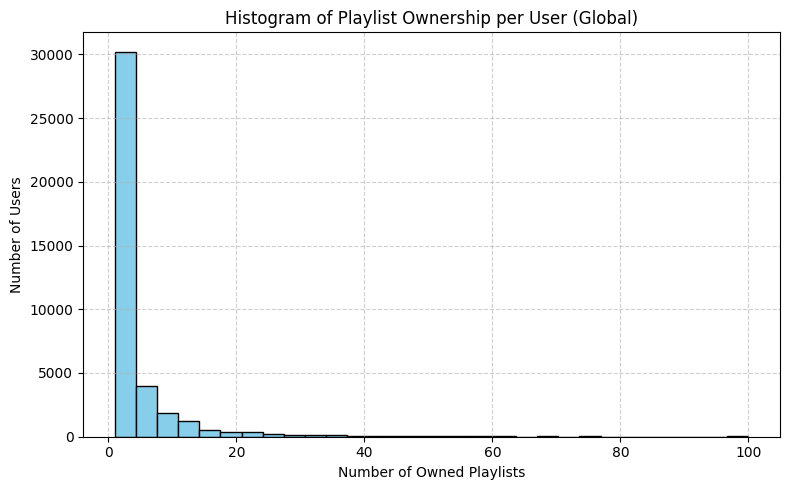


üìä Extreme Users (owning > 5 playlists):
 - Count                   : 7,675
 - Share of owners         : 19.36%
 - Min owned               : 6
 - Max owned               : 100
 - Average owned           : 15.54
 - Median owned            : 10.00
 - 25th percentile         : 7.00
 - 75th percentile         : 17.00


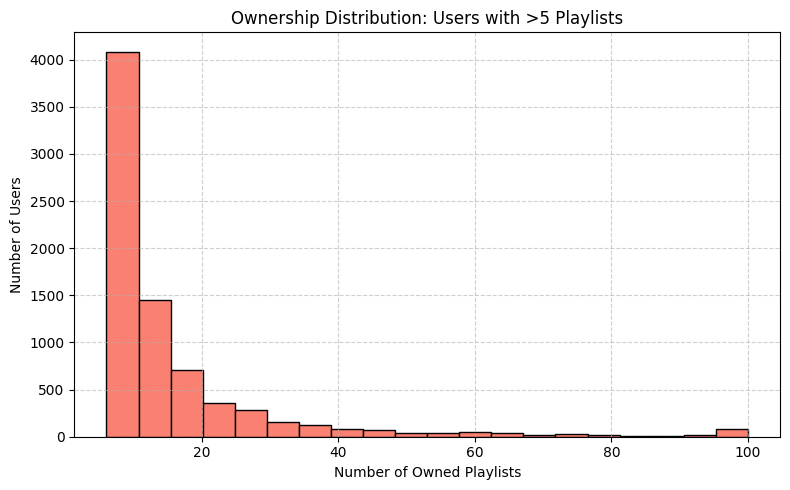


üìä Playlist Ownership Inequality Stats:
 - Top 1% own 15.34% of playlists
 - Top 5% own 37.29% of playlists
 - Top 10% own 50.83% of playlists
 - Top 25% own 71.68% of playlists
 - Gini coefficient       : 0.6033


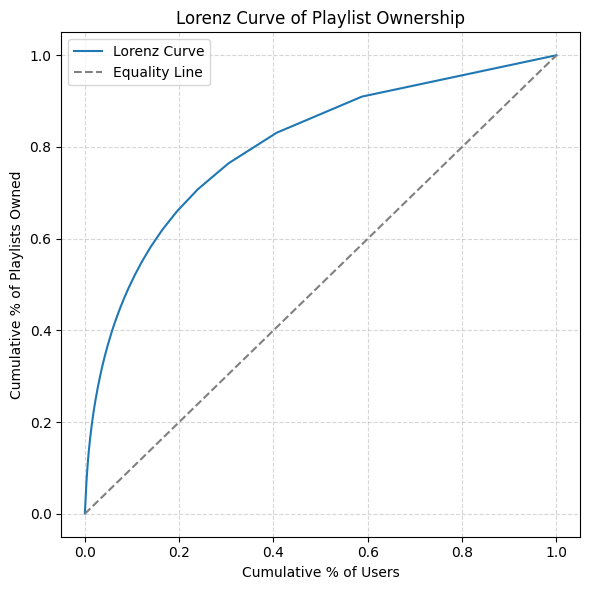


üìä Ownership Coverage in Downscaled Dataset:
 - Total selected users   : 101,713
 - Users with ownership   : 39,653
 - Share with ownership   : 38.99%


In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# === CONFIGURATION ===
OWNERSHIP_PATH = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
SELECTED_USERS_PATH = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled/selected_user_ids.pkl"

# === Load ownership map ===
with open(OWNERSHIP_PATH, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Build ownership stats ===
ownership_counts = [len(playlists) for playlists in user_owned_playlists.values()]
owned_user_ids = set(user_owned_playlists.keys())

# === Show basic stats ===
avg = np.mean(ownership_counts)
med = np.median(ownership_counts)
p25 = np.percentile(ownership_counts, 25)
p75 = np.percentile(ownership_counts, 75)
min_ = np.min(ownership_counts)
max_ = np.max(ownership_counts)

print("Playlist Ownership Stats (Global):")
print(f" - Users with ownership: {len(ownership_counts):,}")
print(f" - Min owned           : {min_}")
print(f" - Max owned           : {max_}")
print(f" - Average owned       : {avg:.2f}")
print(f" - Median owned        : {med}")
print(f" - 25th percentile     : {p25}")
print(f" - 75th percentile     : {p75}")

# === Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(ownership_counts, bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Playlist Ownership per User (Global)")
plt.xlabel("Number of Owned Playlists")
plt.ylabel("Number of Users")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Filter extreme users (more than 5 playlists) ===
extreme_ownership_counts = [v for v in ownership_counts if v > 5]
num_extreme_users = len(extreme_ownership_counts)
share_extreme = (num_extreme_users / len(ownership_counts)) * 100 if ownership_counts else 0

if extreme_ownership_counts:
    print("\nüìä Extreme Users (owning > 5 playlists):")
    print(f" - Count                   : {num_extreme_users:,}")
    print(f" - Share of owners         : {share_extreme:.2f}%")
    print(f" - Min owned               : {min(extreme_ownership_counts)}")
    print(f" - Max owned               : {max(extreme_ownership_counts)}")
    print(f" - Average owned           : {np.mean(extreme_ownership_counts):.2f}")
    print(f" - Median owned            : {np.median(extreme_ownership_counts):.2f}")
    print(f" - 25th percentile         : {np.percentile(extreme_ownership_counts, 25):.2f}")
    print(f" - 75th percentile         : {np.percentile(extreme_ownership_counts, 75):.2f}")

    plt.figure(figsize=(8, 5))
    plt.hist(extreme_ownership_counts, bins=20, color="salmon", edgecolor="black")
    plt.title("Ownership Distribution: Users with >5 Playlists")
    plt.xlabel("Number of Owned Playlists")
    plt.ylabel("Number of Users")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No users own more than 5 playlists.")

# === Inequality stats ===
sorted_ownership = np.array(sorted(ownership_counts, reverse=True), dtype=np.float64)
total_playlists = sorted_ownership.sum()
num_users = len(sorted_ownership)
thresholds = [0.01, 0.05, 0.10, 0.25]

print("\nüìä Playlist Ownership Inequality Stats:")
for t in thresholds:
    top_n = int(num_users * t)
    share = sorted_ownership[:top_n].sum() / total_playlists * 100
    print(f" - Top {int(t*100)}% own {share:.2f}% of playlists")

# === Gini Coefficient ===
def gini_coefficient(x):
    x = np.array(x, dtype=np.float64)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x += 1e-9  # avoid zero division
    x_sorted = np.sort(x)
    n = x.shape[0]
    index = np.arange(1, n + 1)
    return ((np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted)))

gini = gini_coefficient(sorted_ownership)
print(f" - Gini coefficient       : {gini:.4f}")

# === Optional: Lorenz Curve ===
cum_ownership = np.cumsum(sorted_ownership) / total_playlists
cum_users = np.arange(1, num_users + 1) / num_users

plt.figure(figsize=(6, 6))
plt.plot(cum_users, cum_ownership, label="Lorenz Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Equality Line")
plt.xlabel("Cumulative % of Users")
plt.ylabel("Cumulative % of Playlists Owned")
plt.title("Lorenz Curve of Playlist Ownership")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# === Compare to total selected users ===
with open(SELECTED_USERS_PATH, "rb") as f:
    selected_users = pickle.load(f)

total_users = len(selected_users)
owned_users = len(owned_user_ids)
ownership_share = owned_users / total_users * 100

print("\nüìä Ownership Coverage in Downscaled Dataset:")
print(f" - Total selected users   : {total_users:,}")
print(f" - Users with ownership   : {owned_users:,}")
print(f" - Share with ownership   : {ownership_share:.2f}%")

# Part 8) Generate triplets training dataset!

This is the dataset that the BPR model will be trained on.

Each row is a triplet of (user_id, liked_playlist_id, negative_playlist_id).

Apart from the full dataset, we also generate a toy dataset for doing training tests (5% of full-sized dataset).

### i) Precompute the negatives from which we will grab for triplet generation.

- For this we sample negatives, but we take 20% of them strictly from 'hard-negatives', meaning that they are negatives that were close, in score, to being a positive for that user. This makes the task a bit more challenging for the model training, and will probably help it generalize better and perform better in production.
- The other 80% is sampled from all negatives (including hard-negatives).

In [ ]:
import os
import pickle
import polars as pl
from tqdm import tqdm

# === CONFIGURATION ===
INPUT_DIR = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled"
TRAIN_POSITIVES_PATH = "/content/drive/MyDrive/datasets/main_datasets/positives_splits/training_positives.pkl"
OWNED_PLAYLISTS_PATH = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
NEGATIVE_CANDIDATES_PATH = "/content/drive/MyDrive/datasets/main_datasets/negatives/user_negative_candidates.pkl"
RESUME_LOG_PATH = "/content/drive/MyDrive/datasets/main_datasets/negatives/resume_log.pkl"
os.makedirs(os.path.dirname(NEGATIVE_CANDIDATES_PATH), exist_ok=True)

# === Step 1: Load data ===
with open(TRAIN_POSITIVES_PATH, "rb") as f:
    training_positives = pickle.load(f)
with open(OWNED_PLAYLISTS_PATH, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Step 2: Resume-safe setup ===
if os.path.exists(RESUME_LOG_PATH):
    with open(RESUME_LOG_PATH, "rb") as f:
        completed_files = pickle.load(f)
else:
    completed_files = set()

user_negative_candidates = {}

input_files = sorted(f for f in os.listdir(INPUT_DIR) if f.endswith(".parquet"))
remaining_files = [f for f in input_files if f not in completed_files]

# === Step 3: Process slices ===
for file_name in tqdm(remaining_files, desc="Precomputing negatives"):
    df = pl.read_parquet(os.path.join(INPUT_DIR, file_name))

    grouped = df.group_by("user_idx").agg([
        pl.col("playlist_idx").alias("playlist_ids"),
        pl.col("label").alias("labels"),
        pl.col("score").alias("scores"),
    ])

    for row in grouped.iter_rows(named=True):
        user_id = row["user_idx"]
        playlist_ids = row["playlist_ids"]
        labels = row["labels"]
        scores = row["scores"]

        if user_id not in training_positives:
            continue

        positives = set(training_positives[user_id])
        owned = user_owned_playlists.get(user_id, set())

        negatives = [(pid, s) for pid, l, s in zip(playlist_ids, labels, scores)
                     if l == 0 and pid not in positives and pid not in owned]

        if not negatives:
            continue

        negatives.sort(key=lambda x: -x[1])  # descending by score
        cutoff = max(1, int(len(negatives) * 0.2))  # top 20%
        top = [pid for pid, _ in negatives[:cutoff]]
        rest = [pid for pid, _ in negatives[cutoff:]]
        user_negative_candidates[user_id] = {"hard": top, "easy": rest}

    # Save progress
    with open(NEGATIVE_CANDIDATES_PATH, "wb") as f:
        pickle.dump(user_negative_candidates, f)
    completed_files.add(file_name)
    with open(RESUME_LOG_PATH, "wb") as f:
        pickle.dump(completed_files, f)

# Final cleanup
if os.path.exists(RESUME_LOG_PATH):
    os.remove(RESUME_LOG_PATH)

print("‚úÖ Candidate negatives cached for triplet generation.")

Precomputing negatives: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [29:38<00:00, 17.44s/it]

‚úÖ Candidate negatives cached for triplet generation.


### Generate the triplets! (This code takes about 6 hours to run)

In [ ]:
import os
import pickle
import random
from tqdm import tqdm
import polars as pl

# === CONFIGURATION ===
INPUT_DIR = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled"
TRAIN_POSITIVES_PATH = "/content/drive/MyDrive/datasets/main_datasets/positives_splits/training_positives.pkl"
OWNED_PLAYLISTS_PATH = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
NEGATIVE_CANDIDATES_PATH = "/content/drive/MyDrive/datasets/main_datasets/negatives/user_negative_candidates.pkl"

OUTPUT_DIR = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/full"
TOY_OUTPUT_DIR = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/toy"
RESUME_LOG_PATH = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/resume_log_v2.pkl"
TOY_USERS_PATH = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/toy_users.pkl"

NUM_NEGATIVES = 4
TOY_USER_RATIO = 0.05
TOY_MAX_TRIPLETS_PER_SLICE = 10_000_000
SEED = 42
random.seed(SEED)

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TOY_OUTPUT_DIR, exist_ok=True)

# === Step 1: Load data ===
with open(TRAIN_POSITIVES_PATH, "rb") as f:
    training_positives = pickle.load(f)
with open(OWNED_PLAYLISTS_PATH, "rb") as f:
    user_owned_playlists = pickle.load(f)
with open(NEGATIVE_CANDIDATES_PATH, "rb") as f:
    user_negative_candidates = pickle.load(f)

all_users = sorted(training_positives.keys())
sampled_toy_users = set(random.sample(all_users, int(len(all_users) * TOY_USER_RATIO)))

# Save toy user list (if not done already)
with open(TOY_USERS_PATH, "wb") as f:
    pickle.dump(sampled_toy_users, f)
print(f"‚úÖ Saved toy user list: {len(sampled_toy_users)} users ‚Üí {TOY_USERS_PATH}")

# === Step 2: Resume-safe setup ===
if os.path.exists(RESUME_LOG_PATH):
    with open(RESUME_LOG_PATH, "rb") as f:
        completed_files = pickle.load(f)
else:
    completed_files = set()

input_files = sorted(f for f in os.listdir(INPUT_DIR) if f.endswith(".parquet"))
remaining_files = [f for f in input_files if f not in completed_files]

print(f"‚úÖ {len(completed_files)} slices already processed, {len(remaining_files)} remaining.")
print(f"‚úÖ {len(sampled_toy_users)} users sampled for toy dataset.")

# === Step 3: Process slices ===
for file_name in tqdm(remaining_files, desc="Generating triplets (cached negs)"):
    df = pl.read_parquet(os.path.join(INPUT_DIR, file_name))

    grouped = df.group_by("user_idx").agg([
        pl.col("playlist_idx").alias("playlist_ids"),
        pl.col("label").alias("labels")
    ])

    triplets = []
    toy_triplets = []

    for row in grouped.iter_rows(named=True):
        user_id = row["user_idx"]
        playlist_ids = row["playlist_ids"]
        labels = row["labels"]

        positives = [pid for pid, label in zip(playlist_ids, labels) if label == 1]
        if user_id not in training_positives or user_id not in user_negative_candidates:
            continue
        positives = [pid for pid in positives if pid in training_positives[user_id]]
        if not positives:
            continue

        hard_pool = user_negative_candidates[user_id].get("hard", [])
        easy_pool = user_negative_candidates[user_id].get("easy", [])

        # Skip if not enough total negatives
        if len(hard_pool) + len(easy_pool) < NUM_NEGATIVES:
            continue

        for pos_pid in positives:
            hard_sample = random.sample(hard_pool, min(NUM_NEGATIVES // 2, len(hard_pool))) if hard_pool else []
            required_easy = NUM_NEGATIVES - len(hard_sample)
            if len(easy_pool) < required_easy:
                continue
            easy_sample = random.sample(easy_pool, required_easy)
            negs = hard_sample + easy_sample
            for neg_pid in negs:
                triplets.append((user_id, pos_pid, neg_pid))
                if user_id in sampled_toy_users:
                    toy_triplets.append((user_id, pos_pid, neg_pid))

    # Save full dataset slice
    df_triplet = pl.DataFrame(triplets, schema=["user_id", "pos_pid", "neg_pid"])
    df_triplet.write_parquet(os.path.join(OUTPUT_DIR, "triplets_" + file_name))

    # Save toy dataset slice
    if toy_triplets:
        df_toy = pl.DataFrame(toy_triplets, schema=["user_id", "pos_pid", "neg_pid"])
        if df_toy.shape[0] > TOY_MAX_TRIPLETS_PER_SLICE:
            df_toy = df_toy.sample(n=TOY_MAX_TRIPLETS_PER_SLICE)
        df_toy.write_parquet(os.path.join(TOY_OUTPUT_DIR, "triplets_" + file_name))

    # Update resume log
    completed_files.add(file_name)
    with open(RESUME_LOG_PATH, "wb") as f:
        pickle.dump(completed_files, f)

    print(f"‚úÖ Saved: {file_name} | Triplets: {len(triplets)} | Toy: {len(toy_triplets)}")

print("‚úÖ‚úÖ All triplet slices generated.")
if os.path.exists(RESUME_LOG_PATH):
    os.remove(RESUME_LOG_PATH)

‚úÖ Saved toy user list: 4831 users ‚Üí /content/drive/MyDrive/datasets/main_datasets/triplets_dataset/toy_users.pkl
‚úÖ 0 slices already processed, 102 remaining.
‚úÖ 4831 users sampled for toy dataset.


Generating triplets (cached negs):   0%|          | 0/102 [00:00<?, ?it/s]<ipython-input-7-a2a68180b090>:100: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df_triplet = pl.DataFrame(triplets, schema=["user_id", "pos_pid", "neg_pid"])
<ipython-input-7-a2a68180b090>:105: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df_toy = pl.DataFrame(toy_triplets, schema=["user_id", "pos_pid", "neg_pid"])
Generating triplets (cached negs):   1%|          | 1/102 [00:10<16:58, 10.08s/it]

‚úÖ Saved: labeled_scored_overlap_0_10000.parquet | Triplets: 888160 | Toy: 28204


Generating triplets (cached negs):   2%|‚ñè         | 2/102 [00:15<11:59,  7.20s/it]

‚úÖ Saved: labeled_scored_overlap_1000000_1010000.parquet | Triplets: 851932 | Toy: 39420


Generating triplets (cached negs):   3%|‚ñé         | 3/102 [00:18<09:02,  5.48s/it]

‚úÖ Saved: labeled_scored_overlap_100000_110000.parquet | Triplets: 891376 | Toy: 61316


Generating triplets (cached negs):   4%|‚ñç         | 4/102 [00:22<07:35,  4.65s/it]

‚úÖ Saved: labeled_scored_overlap_10000_20000.parquet | Triplets: 861440 | Toy: 42140


Generating triplets (cached negs):   5%|‚ñç         | 5/102 [00:31<10:19,  6.39s/it]

‚úÖ Saved: labeled_scored_overlap_1010000_1019318.parquet | Triplets: 844656 | Toy: 32548


Generating triplets (cached negs):   6%|‚ñå         | 6/102 [00:34<08:32,  5.34s/it]

‚úÖ Saved: labeled_scored_overlap_110000_120000.parquet | Triplets: 853556 | Toy: 35396


Generating triplets (cached negs):   7%|‚ñã         | 7/102 [00:38<07:37,  4.82s/it]

‚úÖ Saved: labeled_scored_overlap_120000_130000.parquet | Triplets: 947524 | Toy: 56864


Generating triplets (cached negs):   8%|‚ñä         | 8/102 [00:42<06:54,  4.41s/it]

‚úÖ Saved: labeled_scored_overlap_130000_140000.parquet | Triplets: 886964 | Toy: 64700


Generating triplets (cached negs):   9%|‚ñâ         | 9/102 [00:45<06:20,  4.09s/it]

‚úÖ Saved: labeled_scored_overlap_140000_150000.parquet | Triplets: 865840 | Toy: 38904


Generating triplets (cached negs):  10%|‚ñâ         | 10/102 [00:48<05:50,  3.81s/it]

‚úÖ Saved: labeled_scored_overlap_150000_160000.parquet | Triplets: 817108 | Toy: 43348


Generating triplets (cached negs):  11%|‚ñà         | 11/102 [00:52<05:37,  3.71s/it]

‚úÖ Saved: labeled_scored_overlap_160000_170000.parquet | Triplets: 884696 | Toy: 32724


Generating triplets (cached negs):  12%|‚ñà‚ñè        | 12/102 [00:55<05:29,  3.66s/it]

‚úÖ Saved: labeled_scored_overlap_170000_180000.parquet | Triplets: 905484 | Toy: 38884


Generating triplets (cached negs):  13%|‚ñà‚ñé        | 13/102 [00:59<05:25,  3.66s/it]

‚úÖ Saved: labeled_scored_overlap_180000_190000.parquet | Triplets: 930792 | Toy: 52368


Generating triplets (cached negs):  14%|‚ñà‚ñé        | 14/102 [01:03<05:21,  3.66s/it]

‚úÖ Saved: labeled_scored_overlap_190000_200000.parquet | Triplets: 910376 | Toy: 36220


Generating triplets (cached negs):  15%|‚ñà‚ñç        | 15/102 [01:06<05:13,  3.61s/it]

‚úÖ Saved: labeled_scored_overlap_200000_210000.parquet | Triplets: 887360 | Toy: 60632


Generating triplets (cached negs):  16%|‚ñà‚ñå        | 16/102 [01:09<05:00,  3.49s/it]

‚úÖ Saved: labeled_scored_overlap_20000_30000.parquet | Triplets: 845060 | Toy: 43600


Generating triplets (cached negs):  17%|‚ñà‚ñã        | 17/102 [01:12<04:50,  3.42s/it]

‚úÖ Saved: labeled_scored_overlap_210000_220000.parquet | Triplets: 881268 | Toy: 45136


Generating triplets (cached negs):  18%|‚ñà‚ñä        | 18/102 [01:16<04:50,  3.46s/it]

‚úÖ Saved: labeled_scored_overlap_220000_230000.parquet | Triplets: 935040 | Toy: 41764


Generating triplets (cached negs):  19%|‚ñà‚ñä        | 19/102 [01:19<04:46,  3.45s/it]

‚úÖ Saved: labeled_scored_overlap_230000_240000.parquet | Triplets: 903608 | Toy: 30576


Generating triplets (cached negs):  20%|‚ñà‚ñâ        | 20/102 [01:23<04:39,  3.41s/it]

‚úÖ Saved: labeled_scored_overlap_240000_250000.parquet | Triplets: 855064 | Toy: 37728


Generating triplets (cached negs):  21%|‚ñà‚ñà        | 21/102 [01:26<04:37,  3.43s/it]

‚úÖ Saved: labeled_scored_overlap_250000_260000.parquet | Triplets: 899628 | Toy: 49136


Generating triplets (cached negs):  22%|‚ñà‚ñà‚ñè       | 22/102 [01:30<04:37,  3.47s/it]

‚úÖ Saved: labeled_scored_overlap_260000_270000.parquet | Triplets: 914756 | Toy: 48268


Generating triplets (cached negs):  23%|‚ñà‚ñà‚ñé       | 23/102 [01:33<04:31,  3.44s/it]

‚úÖ Saved: labeled_scored_overlap_270000_280000.parquet | Triplets: 882016 | Toy: 35628


Generating triplets (cached negs):  24%|‚ñà‚ñà‚ñé       | 24/102 [01:37<04:27,  3.42s/it]

‚úÖ Saved: labeled_scored_overlap_280000_290000.parquet | Triplets: 897072 | Toy: 34428


Generating triplets (cached negs):  25%|‚ñà‚ñà‚ñç       | 25/102 [01:40<04:22,  3.41s/it]

‚úÖ Saved: labeled_scored_overlap_290000_300000.parquet | Triplets: 888140 | Toy: 30320


Generating triplets (cached negs):  25%|‚ñà‚ñà‚ñå       | 26/102 [01:44<04:24,  3.48s/it]

‚úÖ Saved: labeled_scored_overlap_300000_310000.parquet | Triplets: 941772 | Toy: 58048


Generating triplets (cached negs):  26%|‚ñà‚ñà‚ñã       | 27/102 [01:47<04:22,  3.50s/it]

‚úÖ Saved: labeled_scored_overlap_30000_40000.parquet | Triplets: 924012 | Toy: 44716


Generating triplets (cached negs):  27%|‚ñà‚ñà‚ñã       | 28/102 [01:51<04:16,  3.47s/it]

‚úÖ Saved: labeled_scored_overlap_310000_320000.parquet | Triplets: 873664 | Toy: 46164


Generating triplets (cached negs):  28%|‚ñà‚ñà‚ñä       | 29/102 [01:54<04:09,  3.42s/it]

‚úÖ Saved: labeled_scored_overlap_320000_330000.parquet | Triplets: 836640 | Toy: 40496


Generating triplets (cached negs):  29%|‚ñà‚ñà‚ñâ       | 30/102 [01:57<04:04,  3.40s/it]

‚úÖ Saved: labeled_scored_overlap_330000_340000.parquet | Triplets: 861920 | Toy: 58524


Generating triplets (cached negs):  30%|‚ñà‚ñà‚ñà       | 31/102 [02:00<03:57,  3.35s/it]

‚úÖ Saved: labeled_scored_overlap_340000_350000.parquet | Triplets: 839032 | Toy: 42096


Generating triplets (cached negs):  31%|‚ñà‚ñà‚ñà‚ñè      | 32/102 [02:04<03:54,  3.35s/it]

‚úÖ Saved: labeled_scored_overlap_350000_360000.parquet | Triplets: 865516 | Toy: 30716


Generating triplets (cached negs):  32%|‚ñà‚ñà‚ñà‚ñè      | 33/102 [02:07<03:52,  3.37s/it]

‚úÖ Saved: labeled_scored_overlap_360000_370000.parquet | Triplets: 850096 | Toy: 56164


Generating triplets (cached negs):  33%|‚ñà‚ñà‚ñà‚ñé      | 34/102 [02:11<03:51,  3.40s/it]

‚úÖ Saved: labeled_scored_overlap_370000_380000.parquet | Triplets: 874904 | Toy: 68336


Generating triplets (cached negs):  34%|‚ñà‚ñà‚ñà‚ñç      | 35/102 [02:14<03:44,  3.35s/it]

‚úÖ Saved: labeled_scored_overlap_380000_390000.parquet | Triplets: 834776 | Toy: 48960


Generating triplets (cached negs):  35%|‚ñà‚ñà‚ñà‚ñå      | 36/102 [02:24<05:54,  5.37s/it]

‚úÖ Saved: labeled_scored_overlap_390000_400000.parquet | Triplets: 903136 | Toy: 37328


Generating triplets (cached negs):  36%|‚ñà‚ñà‚ñà‚ñã      | 37/102 [02:27<05:08,  4.75s/it]

‚úÖ Saved: labeled_scored_overlap_400000_410000.parquet | Triplets: 860352 | Toy: 50808


Generating triplets (cached negs):  37%|‚ñà‚ñà‚ñà‚ñã      | 38/102 [02:31<04:42,  4.42s/it]

‚úÖ Saved: labeled_scored_overlap_40000_50000.parquet | Triplets: 943884 | Toy: 53000


Generating triplets (cached negs):  38%|‚ñà‚ñà‚ñà‚ñä      | 39/102 [02:34<04:21,  4.16s/it]

‚úÖ Saved: labeled_scored_overlap_410000_420000.parquet | Triplets: 919004 | Toy: 54060


Generating triplets (cached negs):  39%|‚ñà‚ñà‚ñà‚ñâ      | 40/102 [02:38<04:03,  3.93s/it]

‚úÖ Saved: labeled_scored_overlap_420000_430000.parquet | Triplets: 878928 | Toy: 46760


Generating triplets (cached negs):  40%|‚ñà‚ñà‚ñà‚ñà      | 41/102 [02:41<03:47,  3.72s/it]

‚úÖ Saved: labeled_scored_overlap_430000_440000.parquet | Triplets: 838736 | Toy: 32288


Generating triplets (cached negs):  41%|‚ñà‚ñà‚ñà‚ñà      | 42/102 [02:45<03:39,  3.66s/it]

‚úÖ Saved: labeled_scored_overlap_440000_450000.parquet | Triplets: 888824 | Toy: 40316


Generating triplets (cached negs):  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 43/102 [02:48<03:33,  3.61s/it]

‚úÖ Saved: labeled_scored_overlap_450000_460000.parquet | Triplets: 908856 | Toy: 57848


Generating triplets (cached negs):  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 44/102 [02:51<03:23,  3.51s/it]

‚úÖ Saved: labeled_scored_overlap_460000_470000.parquet | Triplets: 872676 | Toy: 37756


Generating triplets (cached negs):  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 45/102 [02:55<03:19,  3.50s/it]

‚úÖ Saved: labeled_scored_overlap_470000_480000.parquet | Triplets: 882172 | Toy: 37048


Generating triplets (cached negs):  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 46/102 [02:58<03:15,  3.48s/it]

‚úÖ Saved: labeled_scored_overlap_480000_490000.parquet | Triplets: 870564 | Toy: 36408


Generating triplets (cached negs):  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 47/102 [03:02<03:12,  3.49s/it]

‚úÖ Saved: labeled_scored_overlap_490000_500000.parquet | Triplets: 912856 | Toy: 27312


Generating triplets (cached negs):  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 48/102 [03:05<03:04,  3.42s/it]

‚úÖ Saved: labeled_scored_overlap_500000_510000.parquet | Triplets: 831312 | Toy: 40784


Generating triplets (cached negs):  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 49/102 [03:09<03:02,  3.45s/it]

‚úÖ Saved: labeled_scored_overlap_50000_60000.parquet | Triplets: 904788 | Toy: 51024


Generating triplets (cached negs):  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 50/102 [03:12<02:57,  3.42s/it]

‚úÖ Saved: labeled_scored_overlap_510000_520000.parquet | Triplets: 859528 | Toy: 35676


Generating triplets (cached negs):  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 51/102 [03:15<02:53,  3.40s/it]

‚úÖ Saved: labeled_scored_overlap_520000_530000.parquet | Triplets: 857468 | Toy: 49172


Generating triplets (cached negs):  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 52/102 [03:19<02:51,  3.42s/it]

‚úÖ Saved: labeled_scored_overlap_530000_540000.parquet | Triplets: 879628 | Toy: 29272


Generating triplets (cached negs):  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 53/102 [03:23<02:52,  3.52s/it]

‚úÖ Saved: labeled_scored_overlap_540000_550000.parquet | Triplets: 940364 | Toy: 42064


Generating triplets (cached negs):  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 54/102 [03:26<02:49,  3.53s/it]

‚úÖ Saved: labeled_scored_overlap_550000_560000.parquet | Triplets: 905760 | Toy: 36276


Generating triplets (cached negs):  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 55/102 [03:30<02:49,  3.60s/it]

‚úÖ Saved: labeled_scored_overlap_560000_570000.parquet | Triplets: 954596 | Toy: 48452


Generating triplets (cached negs):  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 56/102 [03:33<02:42,  3.53s/it]

‚úÖ Saved: labeled_scored_overlap_570000_580000.parquet | Triplets: 816308 | Toy: 36880


Generating triplets (cached negs):  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 57/102 [03:37<02:37,  3.50s/it]

‚úÖ Saved: labeled_scored_overlap_580000_590000.parquet | Triplets: 851696 | Toy: 34156


Generating triplets (cached negs):  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 58/102 [03:40<02:36,  3.56s/it]

‚úÖ Saved: labeled_scored_overlap_590000_600000.parquet | Triplets: 910244 | Toy: 37612


Generating triplets (cached negs):  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 59/102 [03:44<02:31,  3.52s/it]

‚úÖ Saved: labeled_scored_overlap_600000_610000.parquet | Triplets: 827324 | Toy: 36192


Generating triplets (cached negs):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 60/102 [03:47<02:27,  3.52s/it]

‚úÖ Saved: labeled_scored_overlap_60000_70000.parquet | Triplets: 857872 | Toy: 48364


Generating triplets (cached negs):  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 61/102 [03:51<02:27,  3.61s/it]

‚úÖ Saved: labeled_scored_overlap_610000_620000.parquet | Triplets: 959460 | Toy: 51356


Generating triplets (cached negs):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 62/102 [03:54<02:21,  3.54s/it]

‚úÖ Saved: labeled_scored_overlap_620000_630000.parquet | Triplets: 833440 | Toy: 50188


Generating triplets (cached negs):  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 63/102 [03:58<02:18,  3.56s/it]

‚úÖ Saved: labeled_scored_overlap_630000_640000.parquet | Triplets: 910632 | Toy: 49248


Generating triplets (cached negs):  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 64/102 [04:02<02:14,  3.54s/it]

‚úÖ Saved: labeled_scored_overlap_640000_650000.parquet | Triplets: 887204 | Toy: 52420


Generating triplets (cached negs):  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 65/102 [04:05<02:10,  3.53s/it]

‚úÖ Saved: labeled_scored_overlap_650000_660000.parquet | Triplets: 889004 | Toy: 44144


Generating triplets (cached negs):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 66/102 [04:09<02:07,  3.56s/it]

‚úÖ Saved: labeled_scored_overlap_660000_670000.parquet | Triplets: 890860 | Toy: 34000


Generating triplets (cached negs):  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 67/102 [04:19<03:15,  5.58s/it]

‚úÖ Saved: labeled_scored_overlap_670000_680000.parquet | Triplets: 885636 | Toy: 44052


Generating triplets (cached negs):  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 68/102 [04:23<02:48,  4.97s/it]

‚úÖ Saved: labeled_scored_overlap_680000_690000.parquet | Triplets: 872708 | Toy: 35456


Generating triplets (cached negs):  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 69/102 [04:26<02:30,  4.57s/it]

‚úÖ Saved: labeled_scored_overlap_690000_700000.parquet | Triplets: 866776 | Toy: 30236


Generating triplets (cached negs):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 70/102 [04:30<02:18,  4.32s/it]

‚úÖ Saved: labeled_scored_overlap_700000_710000.parquet | Triplets: 844040 | Toy: 53048


Generating triplets (cached negs):  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 71/102 [04:34<02:10,  4.20s/it]

‚úÖ Saved: labeled_scored_overlap_70000_80000.parquet | Triplets: 901252 | Toy: 46928


Generating triplets (cached negs):  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 72/102 [04:38<02:01,  4.05s/it]

‚úÖ Saved: labeled_scored_overlap_710000_720000.parquet | Triplets: 905600 | Toy: 41136


Generating triplets (cached negs):  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 73/102 [04:41<01:54,  3.94s/it]

‚úÖ Saved: labeled_scored_overlap_720000_730000.parquet | Triplets: 931476 | Toy: 42756


Generating triplets (cached negs):  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 74/102 [04:45<01:51,  3.98s/it]

‚úÖ Saved: labeled_scored_overlap_730000_740000.parquet | Triplets: 939348 | Toy: 47300


Generating triplets (cached negs):  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 75/102 [04:49<01:46,  3.94s/it]

‚úÖ Saved: labeled_scored_overlap_740000_750000.parquet | Triplets: 939060 | Toy: 38276


Generating triplets (cached negs):  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 76/102 [04:53<01:37,  3.76s/it]

‚úÖ Saved: labeled_scored_overlap_750000_760000.parquet | Triplets: 845988 | Toy: 38448


Generating triplets (cached negs):  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 77/102 [04:56<01:32,  3.71s/it]

‚úÖ Saved: labeled_scored_overlap_760000_770000.parquet | Triplets: 881632 | Toy: 47620


Generating triplets (cached negs):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 78/102 [05:00<01:27,  3.65s/it]

‚úÖ Saved: labeled_scored_overlap_770000_780000.parquet | Triplets: 827016 | Toy: 40004


Generating triplets (cached negs):  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 79/102 [05:03<01:24,  3.66s/it]

‚úÖ Saved: labeled_scored_overlap_780000_790000.parquet | Triplets: 900088 | Toy: 32464


Generating triplets (cached negs):  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 80/102 [05:07<01:18,  3.56s/it]

‚úÖ Saved: labeled_scored_overlap_790000_800000.parquet | Triplets: 826324 | Toy: 47264


Generating triplets (cached negs):  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 81/102 [05:10<01:16,  3.63s/it]

‚úÖ Saved: labeled_scored_overlap_800000_810000.parquet | Triplets: 909820 | Toy: 42516


Generating triplets (cached negs):  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 82/102 [05:14<01:12,  3.61s/it]

‚úÖ Saved: labeled_scored_overlap_80000_90000.parquet | Triplets: 870708 | Toy: 38732


Generating triplets (cached negs):  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 83/102 [05:17<01:06,  3.52s/it]

‚úÖ Saved: labeled_scored_overlap_810000_820000.parquet | Triplets: 847940 | Toy: 44844


Generating triplets (cached negs):  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 84/102 [05:21<01:04,  3.56s/it]

‚úÖ Saved: labeled_scored_overlap_820000_830000.parquet | Triplets: 883596 | Toy: 54756


Generating triplets (cached negs):  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 85/102 [05:25<01:01,  3.60s/it]

‚úÖ Saved: labeled_scored_overlap_830000_840000.parquet | Triplets: 923180 | Toy: 48976


Generating triplets (cached negs):  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 86/102 [05:29<00:59,  3.71s/it]

‚úÖ Saved: labeled_scored_overlap_840000_850000.parquet | Triplets: 983504 | Toy: 37432


Generating triplets (cached negs):  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 87/102 [05:32<00:54,  3.63s/it]

‚úÖ Saved: labeled_scored_overlap_850000_860000.parquet | Triplets: 855624 | Toy: 40020


Generating triplets (cached negs):  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 88/102 [05:36<00:50,  3.59s/it]

‚úÖ Saved: labeled_scored_overlap_860000_870000.parquet | Triplets: 873628 | Toy: 35532


Generating triplets (cached negs):  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 89/102 [05:39<00:46,  3.54s/it]

‚úÖ Saved: labeled_scored_overlap_870000_880000.parquet | Triplets: 862580 | Toy: 31040


Generating triplets (cached negs):  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 90/102 [05:43<00:42,  3.57s/it]

‚úÖ Saved: labeled_scored_overlap_880000_890000.parquet | Triplets: 908344 | Toy: 67264


Generating triplets (cached negs):  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 91/102 [05:46<00:39,  3.56s/it]

‚úÖ Saved: labeled_scored_overlap_890000_900000.parquet | Triplets: 875260 | Toy: 42008


Generating triplets (cached negs):  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 92/102 [05:50<00:35,  3.55s/it]

‚úÖ Saved: labeled_scored_overlap_900000_910000.parquet | Triplets: 877224 | Toy: 54740


Generating triplets (cached negs):  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 93/102 [05:53<00:31,  3.54s/it]

‚úÖ Saved: labeled_scored_overlap_90000_100000.parquet | Triplets: 879044 | Toy: 46528


Generating triplets (cached negs):  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 94/102 [05:57<00:28,  3.61s/it]

‚úÖ Saved: labeled_scored_overlap_910000_920000.parquet | Triplets: 944208 | Toy: 56864


Generating triplets (cached negs):  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 95/102 [06:00<00:24,  3.57s/it]

‚úÖ Saved: labeled_scored_overlap_920000_930000.parquet | Triplets: 840252 | Toy: 39968


Generating triplets (cached negs):  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 96/102 [06:04<00:21,  3.59s/it]

‚úÖ Saved: labeled_scored_overlap_930000_940000.parquet | Triplets: 875132 | Toy: 50504


Generating triplets (cached negs):  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 97/102 [06:08<00:18,  3.66s/it]

‚úÖ Saved: labeled_scored_overlap_940000_950000.parquet | Triplets: 941816 | Toy: 49500


Generating triplets (cached negs):  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 98/102 [06:18<00:22,  5.64s/it]

‚úÖ Saved: labeled_scored_overlap_950000_960000.parquet | Triplets: 912912 | Toy: 32836


Generating triplets (cached negs):  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 99/102 [06:22<00:15,  5.10s/it]

‚úÖ Saved: labeled_scored_overlap_960000_970000.parquet | Triplets: 940808 | Toy: 38564


Generating triplets (cached negs):  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 100/102 [06:25<00:09,  4.58s/it]

‚úÖ Saved: labeled_scored_overlap_970000_980000.parquet | Triplets: 835876 | Toy: 47684


Generating triplets (cached negs):  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 101/102 [06:29<00:04,  4.32s/it]

‚úÖ Saved: labeled_scored_overlap_980000_990000.parquet | Triplets: 910880 | Toy: 51340


Generating triplets (cached negs): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [06:33<00:00,  3.86s/it]

‚úÖ Saved: labeled_scored_overlap_990000_1000000.parquet | Triplets: 940184 | Toy: 44856
‚úÖ‚úÖ All triplet slices generated.


## Save a unique triplets file in pytorch format for both full and toy. We also shuffle here!

In [ ]:
import os
import torch
import polars as pl
from tqdm import tqdm

# === CONFIG ===
FULL_DIR = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/full"
TOY_DIR = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/toy"
FULL_OUT = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/training_triplets_full.pt"
TOY_OUT = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/training_triplets_toy.pt"
SHUFFLE_SEED = 42  # fixed seed for reproducibility

# === Helper: Load and concatenate Parquet triplets ===
def load_triplets_from_dir(directory):
    all_triplets = []
    files = sorted([
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.endswith(".parquet") and f.startswith("triplets")
    ])
    print(f"Found {len(files)} triplet slices in: {directory}")
    for file in tqdm(files, desc=f"Loading {os.path.basename(directory)}"):
        df = pl.read_parquet(file)
        tensor = torch.tensor(df.to_numpy(), dtype=torch.long)
        all_triplets.append(tensor)
    return torch.cat(all_triplets, dim=0)

# === Step 1: Load and combine ===
full_triplets = load_triplets_from_dir(FULL_DIR)
toy_triplets = load_triplets_from_dir(TOY_DIR)

# === Step 2: Shuffle with fixed seed ===
torch.manual_seed(SHUFFLE_SEED)
full_perm = torch.randperm(full_triplets.size(0))
full_triplets = full_triplets[full_perm]

torch.manual_seed(SHUFFLE_SEED)
toy_perm = torch.randperm(toy_triplets.size(0))
toy_triplets = toy_triplets[toy_perm]

# === Step 3: Save as .pt ===
torch.save(full_triplets, FULL_OUT)
torch.save(toy_triplets, TOY_OUT)

print(f"‚úÖ Saved: {FULL_OUT} with shape {full_triplets.shape}")
print(f"‚úÖ Saved: {TOY_OUT} with shape {toy_triplets.shape}")


Found 102 triplet slices in: /content/drive/MyDrive/datasets/main_datasets/triplets_dataset/full


Loading full: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [00:02<00:00, 34.65it/s]


Found 102 triplet slices in: /content/drive/MyDrive/datasets/main_datasets/triplets_dataset/toy


Loading toy: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 102/102 [00:00<00:00, 112.21it/s]


‚úÖ Saved: /content/drive/MyDrive/datasets/main_datasets/triplets_dataset/training_triplets.pt with shape torch.Size([90338188, 3])
‚úÖ Saved: /content/drive/MyDrive/datasets/main_datasets/triplets_dataset/training_triplets_toy.pt with shape torch.Size([4454176, 3])



Randomly Selected Triplet Files:
 - triplets_labeled_scored_overlap_660000_670000.parquet
 - triplets_labeled_scored_overlap_110000_120000.parquet
 - triplets_labeled_scored_overlap_750000_760000.parquet

üìä Stats for triplets_labeled_scored_overlap_660000_670000.parquet:
 - Users in slice        : 945
 - Total triplets        : 890,860
 - Mean                  : 942.71
 - Min                   : 4
 - Max                   : 10532
 - P1                    : 4.00
 - P25                   : 152.00
 - P50 (Median)          : 576.00
 - P75                   : 1248.00
 - P99                   : 6686.72


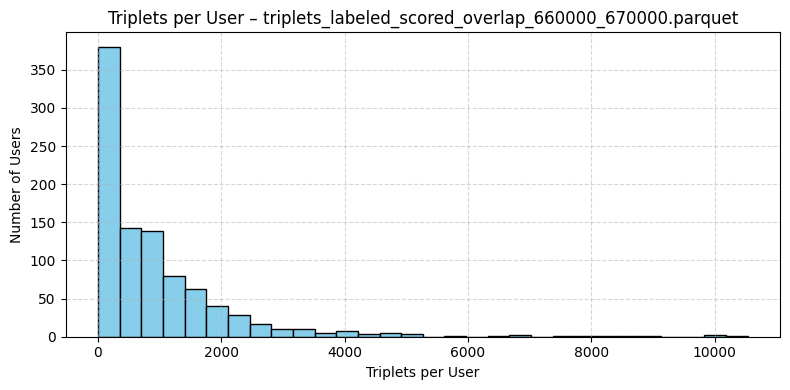


üìä Stats for triplets_labeled_scored_overlap_110000_120000.parquet:
 - Users in slice        : 938
 - Total triplets        : 853,556
 - Mean                  : 909.97
 - Min                   : 4
 - Max                   : 11372
 - P1                    : 8.00
 - P25                   : 120.00
 - P50 (Median)          : 512.00
 - P75                   : 1231.00
 - P99                   : 5416.00


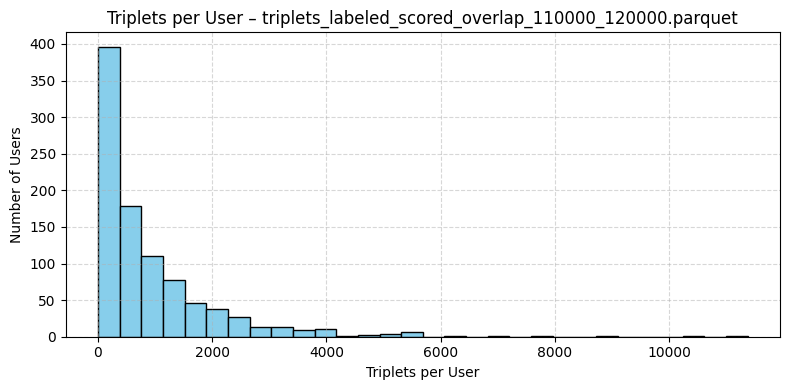


üìä Stats for triplets_labeled_scored_overlap_750000_760000.parquet:
 - Users in slice        : 942
 - Total triplets        : 845,988
 - Mean                  : 898.08
 - Min                   : 4
 - Max                   : 8828
 - P1                    : 4.00
 - P25                   : 148.00
 - P50 (Median)          : 564.00
 - P75                   : 1297.00
 - P99                   : 4478.36


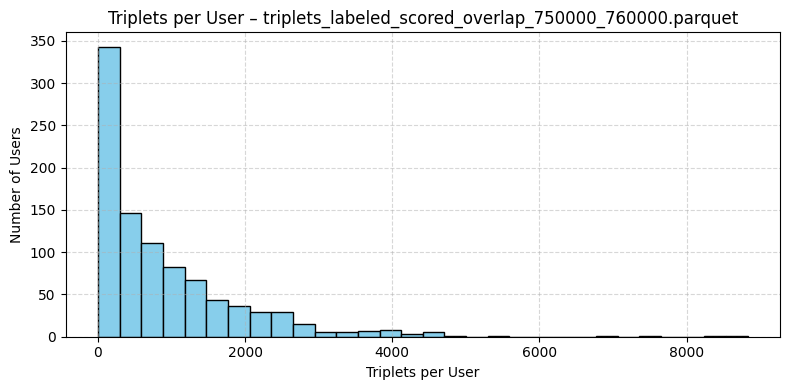

In [ ]:
## Check if triplets generation went well

import os
import random
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# === Configuration ===
TRIPLET_DIR = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/full"
NUM_SAMPLES = 3

# === Randomly select 3 triplet files ===
triplet_files = sorted([f for f in os.listdir(TRIPLET_DIR) if f.endswith(".parquet")])
sampled_files = random.sample(triplet_files, NUM_SAMPLES)

print(f"\nRandomly Selected Triplet Files:")
for f in sampled_files:
    print(f" - {f}")

# === Analyze each file ===
for fname in sampled_files:
    path = os.path.join(TRIPLET_DIR, fname)
    df = pl.read_parquet(path)

    # Count triplets per user
    user_counts = defaultdict(int)
    for row in df.iter_rows(named=True):
        user_counts[row["user_id"]] += 1

    triplet_counts = np.array(list(user_counts.values()))

    # === Compute statistics ===
    print(f"\nüìä Stats for {fname}:")
    print(f" - Users in slice        : {len(triplet_counts):,}")
    print(f" - Total triplets        : {df.shape[0]:,}")
    print(f" - Mean                  : {triplet_counts.mean():.2f}")
    print(f" - Min                   : {triplet_counts.min()}")
    print(f" - Max                   : {triplet_counts.max()}")
    print(f" - P1                    : {np.percentile(triplet_counts, 1):.2f}")
    print(f" - P25                   : {np.percentile(triplet_counts, 25):.2f}")
    print(f" - P50 (Median)          : {np.percentile(triplet_counts, 50):.2f}")
    print(f" - P75                   : {np.percentile(triplet_counts, 75):.2f}")
    print(f" - P99                   : {np.percentile(triplet_counts, 99):.2f}")

    # === Plot histogram ===
    plt.figure(figsize=(8, 4))
    plt.hist(triplet_counts, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Triplets per User ‚Äì {fname}")
    plt.xlabel("Triplets per User")
    plt.ylabel("Number of Users")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# Part 9) Prepare validation batches

For each positive playlist in validation, sample 50 negatives.

For each positive playlist, we'll basically put it in a bag with 50 negatives, and we will evaluate how capable is the model to rank higher the positive, given that it hasn't seen it before for this user (nor as positive or as negative).

In [ ]:
import os
import pickle
import random
from tqdm import tqdm
from collections import defaultdict

# === Configuration ===
VAL_POSITIVES_PATH = "/content/drive/MyDrive/datasets/main_datasets/positives_splits/val_positives.pkl"
TRAIN_POSITIVES_PATH = "/content/drive/MyDrive/datasets/main_datasets/positives_splits/training_positives.pkl"
USER_OWNED_PLAYLISTS_PATH = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
NUM_NEGATIVES = 50
SPLIT_INTO = 5
SLICES_OUTPUT_DIR = "/content/drive/MyDrive/datasets/main_datasets/val_eval_batches"
RESUME_LOG_PATH = os.path.join(SLICES_OUTPUT_DIR, "resume_log.pkl")

os.makedirs(SLICES_OUTPUT_DIR, exist_ok=True)

# === Load Data ===
with open(VAL_POSITIVES_PATH, "rb") as f:
    val_positives = pickle.load(f)
with open(TRAIN_POSITIVES_PATH, "rb") as f:
    training_positives = pickle.load(f)
with open(USER_OWNED_PLAYLISTS_PATH, "rb") as f:
    user_owned = pickle.load(f)

# === Build global playlist pool (union of all playlists seen)
all_playlists = set()
for plist in val_positives.values():
    all_playlists.update(plist)
for plist in training_positives.values():
    all_playlists.update(plist)
for plist in user_owned.values():
    all_playlists.update(plist)

# === Resume state if exists
try:
    if os.path.exists(RESUME_LOG_PATH):
        with open(RESUME_LOG_PATH, "rb") as f:
            resume_data = pickle.load(f)
            val_batches = resume_data["val_batches"]
            processed_users = resume_data["processed_users"]
    else:
        val_batches = defaultdict(list)
        processed_users = set()
except (EOFError, pickle.UnpicklingError):
    print("Resume file is corrupted. Starting fresh.")
    os.remove(RESUME_LOG_PATH)
    val_batches = defaultdict(list)
    processed_users = set()

# === Process each user
user_ids = sorted(val_positives.keys())
for idx, user_id in enumerate(tqdm(user_ids, desc="Generating validation batches")):
    if user_id in processed_users:
        continue

    val_pos = val_positives[user_id]
    train_pos = training_positives.get(user_id, set())
    owned = user_owned.get(user_id, set())

    # Build exclusion set
    blacklist = val_pos | train_pos | owned
    negatives_pool = list(all_playlists - blacklist)

    for pos_pid in val_pos:
        if len(negatives_pool) < NUM_NEGATIVES:
            continue
        negatives = random.sample(negatives_pool, NUM_NEGATIVES)
        val_batches[idx % SPLIT_INTO].append((user_id, pos_pid, negatives))

    processed_users.add(user_id)

    # Periodically save progress
    if idx % 100 == 0 or idx == len(user_ids) - 1:
        with open(RESUME_LOG_PATH, "wb") as f:
            pickle.dump({
                "val_batches": val_batches,
                "processed_users": processed_users
            }, f)

# === Save batches
for i in range(SPLIT_INTO):
    out_path = os.path.join(SLICES_OUTPUT_DIR, f"val_eval_batch_{i}.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(val_batches[i], f)

# === Cleanup
if os.path.exists(RESUME_LOG_PATH):
    os.remove(RESUME_LOG_PATH)

print("‚úÖ Validation batches generated and saved.")


Generating validation batches:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 60300/90898 [7:00:59<3:33:37,  2.39it/s]


KeyboardInterrupt: 

In [ ]:
# Had to interrupt execution. Saving some rescue files

import pickle
import os

# === Rescue Paths ===
RESCUE_DIR = "/content/drive/MyDrive/datasets/main_datasets/val_eval_batches/rescue"
os.makedirs(RESCUE_DIR, exist_ok=True)

# Save processed user IDs
with open(os.path.join(RESCUE_DIR, "processed_users_backup.pkl"), "wb") as f:
    pickle.dump(processed_users, f)
print(f"‚úÖ Saved processed_users: {len(processed_users)} users")

# Save partial validation batches
for i in range(SPLIT_INTO):
    part_path = os.path.join(RESCUE_DIR, f"val_batch_backup_{i}.pkl")
    with open(part_path, "wb") as f:
        pickle.dump(val_batches[i], f)
    print(f"‚úÖ Saved val_batch_backup_{i}: {len(val_batches[i])} samples")


‚úÖ Saved processed_users: 60301 users
‚úÖ Saved val_batch_backup_0: 850689 samples
‚úÖ Saved val_batch_backup_1: 847506 samples
‚úÖ Saved val_batch_backup_2: 858694 samples
‚úÖ Saved val_batch_backup_3: 862366 samples
‚úÖ Saved val_batch_backup_4: 851104 samples


In [ ]:
## Resume from rescue files

import os
import pickle
import random
from tqdm import tqdm
from collections import defaultdict

# === Configuration ===
VAL_POSITIVES_PATH = "/content/drive/MyDrive/datasets/main_datasets/positives_splits/val_positives.pkl"
TRAIN_POSITIVES_PATH = "/content/drive/MyDrive/datasets/main_datasets/positives_splits/training_positives.pkl"
USER_OWNED_PLAYLISTS_PATH = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
SLICES_OUTPUT_DIR = "/content/drive/MyDrive/datasets/main_datasets/val_eval_batches"
RESCUE_DIR = os.path.join(SLICES_OUTPUT_DIR, "rescue")

NUM_NEGATIVES = 50
SPLIT_INTO = 5
os.makedirs(SLICES_OUTPUT_DIR, exist_ok=True)

# === Load Data ===
with open(VAL_POSITIVES_PATH, "rb") as f:
    val_positives = pickle.load(f)
with open(TRAIN_POSITIVES_PATH, "rb") as f:
    training_positives = pickle.load(f)
with open(USER_OWNED_PLAYLISTS_PATH, "rb") as f:
    user_owned = pickle.load(f)

# === Build global playlist pool
all_playlists = set()
for plist_dict in (val_positives, training_positives, user_owned):
    for plist in plist_dict.values():
        all_playlists.update(plist)

# === Load rescue files ===
print("Loading rescue data...")
val_batches = defaultdict(list)
for i in range(SPLIT_INTO):
    rescue_path = os.path.join(RESCUE_DIR, f"val_batch_backup_{i}.pkl")
    with open(rescue_path, "rb") as f:
        val_batches[i] = pickle.load(f)

with open(os.path.join(RESCUE_DIR, "processed_users_backup.pkl"), "rb") as f:
    processed_users = pickle.load(f)

print(f"‚úÖ Loaded {len(processed_users)} processed users from rescue")
for i in range(SPLIT_INTO):
    print(f"‚úÖ Loaded batch {i}: {len(val_batches[i])} triplets")

# === Resume processing
user_ids = sorted(val_positives.keys())
for idx, user_id in enumerate(tqdm(user_ids, desc="Resuming validation batches")):
    if user_id in processed_users:
        continue

    val_pos = val_positives[user_id]
    train_pos = training_positives.get(user_id, set())
    owned = user_owned.get(user_id, set())

    blacklist = val_pos | train_pos | owned
    negatives_pool = list(all_playlists - blacklist)

    for pos_pid in val_pos:
        if len(negatives_pool) < NUM_NEGATIVES:
            continue
        negatives = random.sample(negatives_pool, NUM_NEGATIVES)
        val_batches[idx % SPLIT_INTO].append((user_id, pos_pid, negatives))

    processed_users.add(user_id)

    # Save partials every 1000 users
    if idx % 1000 == 0 or idx == len(user_ids) - 1:
        for i in range(SPLIT_INTO):
            with open(os.path.join(SLICES_OUTPUT_DIR, f"val_batch_partial_{i}.pkl"), "wb") as f:
                pickle.dump(val_batches[i], f)
        with open(os.path.join(SLICES_OUTPUT_DIR, "processed_users_partial.pkl"), "wb") as f:
            pickle.dump(processed_users, f)

# === Final save
for i in range(SPLIT_INTO):
    final_path = os.path.join(SLICES_OUTPUT_DIR, f"val_eval_batch_{i}.pkl")
    with open(final_path, "wb") as f:
        pickle.dump(val_batches[i], f)

# === Cleanup
for i in range(SPLIT_INTO):
    part = os.path.join(SLICES_OUTPUT_DIR, f"val_batch_partial_{i}.pkl")
    if os.path.exists(part):
        os.remove(part)
if os.path.exists(os.path.join(SLICES_OUTPUT_DIR, "processed_users_partial.pkl")):
    os.remove(os.path.join(SLICES_OUTPUT_DIR, "processed_users_partial.pkl"))

print("‚úÖ Validation batches completed and saved.")


Loading rescue data...
‚úÖ Loaded 60301 processed users from rescue
‚úÖ Loaded batch 0: 850689 triplets
‚úÖ Loaded batch 1: 847506 triplets
‚úÖ Loaded batch 2: 858694 triplets
‚úÖ Loaded batch 3: 862366 triplets
‚úÖ Loaded batch 4: 851104 triplets


Resuming validation batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 90898/90898 [52:45<00:00, 28.72it/s]


‚úÖ Validation batches completed and saved.


In [ ]:
# === Code Block 3.5: Generate Toy Validation Batch ===

import os
import pickle
from tqdm import tqdm

# === Configuration ===
FULL_BATCH_DIR = "/content/drive/MyDrive/datasets/main_datasets/val_eval_batches"
TOY_USERS_PATH = "/content/drive/MyDrive/datasets/main_datasets/triplets_dataset/toy_users.pkl"
TOY_OUTPUT_PATH = os.path.join(FULL_BATCH_DIR, "val_eval_batch_toy.pkl")

# === Load toy users ===
with open(TOY_USERS_PATH, "rb") as f:
    toy_users = pickle.load(f)

print(f"‚úÖ Loaded {len(toy_users)} toy users.")

# === Load all full batches ===
full_batches = []
for fname in sorted(os.listdir(FULL_BATCH_DIR)):
    if fname.startswith("val_eval_batch_") and fname.endswith(".pkl") and "toy" not in fname:
        with open(os.path.join(FULL_BATCH_DIR, fname), "rb") as f:
            full_batches.extend(pickle.load(f))

print(f"‚úÖ Loaded {len(full_batches):,} validation triplets from full batches.")

# === Filter for toy users ===
toy_batch = [(u, pos, negs) for (u, pos, negs) in tqdm(full_batches, desc="Filtering toy users") if u in toy_users]


# === Save toy validation batch ===
with open(TOY_OUTPUT_PATH, "wb") as f:
    pickle.dump(toy_batch, f)

print(f"‚úÖ Toy validation batch saved: {TOY_OUTPUT_PATH}")
print(f"üìä Total triplets in toy batch: {len(toy_batch):,}")


‚úÖ Loaded 4831 toy users.
‚úÖ Loaded 6,456,802 validation triplets from full batches.


Filtering toy users: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6456802/6456802 [00:24<00:00, 260758.37it/s]


‚úÖ Toy validation batch saved: /content/drive/MyDrive/datasets/main_datasets/val_eval_batches/val_eval_batch_toy.pkl
üìä Total triplets in toy batch: 318,417
